# LIGHT GBM


Librerias


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report,
                             f1_score, precision_score, recall_score, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score)
from sklearn.model_selection import StratifiedKFold
from tools import optimizar_threshold_costo_cv, evaluate_model


Dataset


In [17]:
dataset = pd.read_csv('../../data/processed/fraud_dataset_processed.csv')


In [18]:
# Mover la columna "fraude" al final a la derecha
# Nos quedamos solo con las columnas numéricas (más la columna 'fraude' si existe)
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()

# EXCLUIR columnas que pueden causar data leakage
columns_to_exclude = ['fraude', 'row_id', 'Unnamed: 0', 'score']
if 'fraude' in numeric_cols:
    numeric_cols.remove('fraude')
for col in columns_to_exclude:
    if col in numeric_cols:
        numeric_cols.remove(col)

# Agregar 'fraude' al final
if 'fraude' in dataset.columns:
    numeric_cols.append('fraude')

dataset = dataset[numeric_cols]

# Verificar columnas usadas
print(f"Total de columnas numéricas (sin 'fraude'): {len(numeric_cols) - 1}")
print(f"Columnas usadas: {numeric_cols[:-1] if 'fraude' in numeric_cols else numeric_cols}")


Total de columnas numéricas (sin 'fraude'): 45
Columnas usadas: ['a', 'b', 'c', 'd', 'e', 'f', 'h', 'k', 'l', 'm', 'n', 'q', 'r', 's', 'monto', 'o_is_N', 'o_is_Y', 'o_is_NA', 'b_imputado', 'c_imputado', 'd_imputado', 'f_imputado', 'q_imputado', 'l_imputado', 'm_imputado', 'categoria_id_target_enc', 'categoria_id_freq_enc', 'pais_target_enc', 'pais_freq_enc', 'producto_num_chars', 'producto_num_words', 'producto_num_special_chars', 'producto_avg_word_len', 'producto_freq', 'hora', 'dia_semana', 'dia_mes', 'mes', 'es_fin_de_semana', 'es_nocturno', 'es_horario_laboral', 'hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos']


In [19]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Obtener nombres de columnas para análisis
feature_names = dataset.columns[:-1].tolist()

# Verificar distribución de clases
print("=" * 80)
print("DISTRIBUCIÓN DE CLASES")
print("=" * 80)
print(f"Clase 0 (No Fraude): {np.sum(y == 0):,} ({np.sum(y == 0)/len(y)*100:.2f}%)")
print(f"Clase 1 (Fraude):    {np.sum(y == 1):,} ({np.sum(y == 1)/len(y)*100:.2f}%)")
print(f"Total:               {len(y):,}")

# Calcular ratio de desbalance para balanceo
fraud_count = np.sum(y == 1)
non_fraud_count = np.sum(y == 0)
if fraud_count > 0:
    scale_pos_weight = non_fraud_count / fraud_count
    print(f"\nRatio de desbalance (scale_pos_weight): {scale_pos_weight:.2f}")
else:
    scale_pos_weight = 1.0
    print("\n⚠️ ERROR: No hay casos de fraude!")

# ⚠️ VERIFICAR DATA LEAKAGE: Correlación con target
print("\n" + "=" * 80)
print("VERIFICACIÓN DE DATA LEAKAGE")
print("=" * 80)
X_df = pd.DataFrame(X, columns=feature_names)
y_series = pd.Series(y)

# Calcular correlaciones con el target
correlations = X_df.corrwith(y_series).abs().sort_values(ascending=False)
print("\nTop 10 columnas con mayor correlación con 'fraude':")
print(correlations.head(10))

# Verificar si hay correlación perfecta o casi perfecta
high_corr = correlations[correlations > 0.95]
if len(high_corr) > 0:
    print(f"\n⚠️ ADVERTENCIA: {len(high_corr)} columna(s) con correlación > 0.95 con el target:")
    print(high_corr)
    print("\n⚠️ Esto puede indicar DATA LEAKAGE!")
else:
    print("\n✅ No se encontraron correlaciones perfectas (>0.95) con el target")

# Verificar si alguna columna predice perfectamente el target
print("\n" + "-" * 80)
print("Verificando si alguna columna predice perfectamente el target...")
perfect_predictors = []
for col in feature_names:
    col_idx = feature_names.index(col)
    col_values = X[:, col_idx]
    
    # Verificar si los valores únicos de la columna coinciden perfectamente con el target
    # (esto indicaría que la columna es casi idéntica al target)
    unique_vals = np.unique(col_values)
    
    # Si la columna tiene solo 2 valores únicos (como el target), verificar si coincide
    if len(unique_vals) == 2:
        # Crear un mapeo binario
        val0, val1 = unique_vals
        col_binary = (col_values == val1).astype(int)
        if np.array_equal(col_binary, y):
            perfect_predictors.append(col)
            print(f"⚠️ {col}: Predice PERFECTAMENTE el target (coincidencia 100%)")

if len(perfect_predictors) > 0:
    print(f"\n⚠️ ADVERTENCIA CRÍTICA: {len(perfect_predictors)} columna(s) predicen perfectamente el target:")
    print(perfect_predictors)
    print("⚠️ Estas columnas deben ser ELIMINADAS - son DATA LEAKAGE!")
else:
    print("✅ No se encontraron columnas que predigan perfectamente el target")


DISTRIBUCIÓN DE CLASES
Clase 0 (No Fraude): 242,498 (97.00%)
Clase 1 (Fraude):    7,502 (3.00%)
Total:               250,000

Ratio de desbalance (scale_pos_weight): 32.32

VERIFICACIÓN DE DATA LEAKAGE

Top 10 columnas con mayor correlación con 'fraude':
categoria_id_target_enc    0.234866
o_is_N                     0.222080
o_is_NA                    0.173683
n                          0.134382
l                          0.091730
l_imputado                 0.091730
s                          0.083816
m                          0.073017
m_imputado                 0.072965
q                          0.060914
dtype: float64

✅ No se encontraron correlaciones perfectas (>0.95) con el target

--------------------------------------------------------------------------------
Verificando si alguna columna predice perfectamente el target...
✅ No se encontraron columnas que predigan perfectamente el target


In [20]:
# IMPORTANTE: Convertir la columna 'fraude' a binaria (0/1) si fue normalizada
if 'fraude' in dataset.columns:
    # Verificar valores únicos
    unique_values = dataset['fraude'].unique()
    print(f"Valores únicos en 'fraude' (primeros 10): {sorted(unique_values)[:10]}")
    print(f"Tipo de datos: {dataset['fraude'].dtype}")
    print(f"Min: {dataset['fraude'].min()}, Max: {dataset['fraude'].max()}")
    
    # Si tiene valores continuos (normalizados), convertir a binario
    if dataset['fraude'].dtype in ['float64', 'float32']:
        # Si los valores están normalizados (entre 0 y 1), convertir a binario
        if dataset['fraude'].min() >= 0 and dataset['fraude'].max() <= 1:
            # Convertir: > 0.5 = 1, <= 0.5 = 0
            dataset['fraude'] = (dataset['fraude'] > 0.5).astype(int)
            print("✅ Columna 'fraude' convertida de valores normalizados a binaria (0/1)")
        else:
            # Si tiene valores negativos o > 1, usar > 0 como criterio
            dataset['fraude'] = (dataset['fraude'] > 0).astype(int)
            print("✅ Columna 'fraude' convertida a binaria usando > 0 como criterio")
    elif dataset['fraude'].dtype in ['int64', 'int32']:
        # Si ya es entero, verificar si es binario
        unique_ints = set(dataset['fraude'].unique())
        if unique_ints != {0, 1}:
            # Normalizar: cualquier valor > 0 = 1, 0 = 0
            dataset['fraude'] = (dataset['fraude'] > 0).astype(int)
            print("✅ Columna 'fraude' normalizada a binaria (0/1)")
        else:
            print("✅ Columna 'fraude' ya es binaria (0/1)")
    
    # Verificar resultado
    print(f"\nDespués de la conversión:")
    print(f"  Valores únicos: {sorted(dataset['fraude'].unique())}")
    print(f"  Tipo: {dataset['fraude'].dtype}")


Valores únicos en 'fraude' (primeros 10): [np.int64(0), np.int64(1)]
Tipo de datos: int64
Min: 0, Max: 1
✅ Columna 'fraude' ya es binaria (0/1)

Después de la conversión:
  Valores únicos: [np.int64(0), np.int64(1)]
  Tipo: int64


Split Train Test


In [21]:
# Asegurar que y sea binario (0/1) y de tipo entero
y = y.astype(float)  # Primero convertir a float para manejar cualquier tipo
y = (y > 0.5).astype(int)  # Convertir a binario: > 0.5 = 1, <= 0.5 = 0

# Verificar que solo tenga valores 0 y 1
unique_y = np.unique(y)
print(f"Valores únicos en y: {unique_y}")
print(f"Tipo de y: {y.dtype}")

if len(unique_y) > 2 or not all(val in [0, 1] for val in unique_y):
    print(f"⚠️ Advertencia: y tiene valores {unique_y}, forzando a binario")
    y = (y > 0).astype(int)
    print("✅ y convertido a binario (0/1)")

# Verificar distribución de clases
print("\n" + "=" * 80)
print("DISTRIBUCIÓN DE CLASES (DESPUÉS DE CONVERSIÓN)")
print("=" * 80)
print(f"Clase 0 (No Fraude): {np.sum(y == 0):,} ({np.sum(y == 0)/len(y)*100:.2f}%)")
print(f"Clase 1 (Fraude):    {np.sum(y == 1):,} ({np.sum(y == 1)/len(y)*100:.2f}%)")
print(f"Total:               {len(y):,}")

# Recalcular ratio de desbalance
fraud_count = np.sum(y == 1)
non_fraud_count = np.sum(y == 0)

if fraud_count > 0:
    scale_pos_weight = non_fraud_count / fraud_count
    print(f"\nRatio de desbalance (scale_pos_weight): {scale_pos_weight:.2f}")
else:
    print("\n⚠️ ERROR: No hay casos de fraude en el dataset!")
    scale_pos_weight = 1.0


Valores únicos en y: [0 1]
Tipo de y: int64

DISTRIBUCIÓN DE CLASES (DESPUÉS DE CONVERSIÓN)
Clase 0 (No Fraude): 242,498 (97.00%)
Clase 1 (Fraude):    7,502 (3.00%)
Total:               250,000

Ratio de desbalance (scale_pos_weight): 32.32


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Verificar si hay datos duplicados entre train y test (posible causa de overfitting)
print("=" * 80)
print("VERIFICACIÓN DE DATOS DUPLICADOS")
print("=" * 80)
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Convertir a tuplas para comparar filas completas
train_tuples = [tuple(row) for row in X_train]
test_tuples = [tuple(row) for row in X_test]
train_set = set(train_tuples)
test_set = set(test_tuples)

duplicates = train_set.intersection(test_set)
if len(duplicates) > 0:
    print(f"⚠️ ADVERTENCIA: {len(duplicates)} filas idénticas entre train y test!")
    print("   Esto puede causar overfitting aparente.")
else:
    print("✅ No se encontraron filas idénticas entre train y test")

print(f"\nTrain size: {len(X_train):,}")
print(f"Test size:  {len(X_test):,}")


VERIFICACIÓN DE DATOS DUPLICADOS
✅ No se encontraron filas idénticas entre train y test

Train size: 200,000
Test size:  50,000


Entrenamos


In [23]:
from lightgbm import LGBMClassifier

# Asegurar que y_train sea binario y entero
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Calcular scale_pos_weight para el conjunto de entrenamiento (BALANCEO)
fraud_count_train = np.sum(y_train == 1)
non_fraud_count_train = np.sum(y_train == 0)

print("=" * 80)
print("BALANCEO DE CLASES")
print("=" * 80)
print(f"No Fraude (train): {non_fraud_count_train:,}")
print(f"Fraude (train):    {fraud_count_train:,}")

if fraud_count_train > 0 and non_fraud_count_train > 0:
    scale_pos_weight = non_fraud_count_train / fraud_count_train
    print(f"scale_pos_weight:  {scale_pos_weight:.2f}")
else:
    print("⚠️ ERROR: No hay suficientes muestras de ambas clases!")
    scale_pos_weight = 1.0

# Entrenar modelo con balanceo
print("\n" + "=" * 80)
print("ENTRENANDO MODELO CON BALANCEO")
print("=" * 80)
classifier = LGBMClassifier(
    scale_pos_weight=scale_pos_weight,  # Balanceo de clases
    random_state=0,
    objective='binary',
    metric='binary_logloss',
    n_estimators=100,
    verbose=-1
)
classifier.fit(X_train, y_train)
print("✅ Modelo entrenado con balanceo de clases")


BALANCEO DE CLASES
No Fraude (train): 193,968
Fraude (train):    6,032
scale_pos_weight:  32.16

ENTRENANDO MODELO CON BALANCEO
✅ Modelo entrenado con balanceo de clases


Optimizació de hiperparametros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Definir espacio de hiperparámetros para LightGBM
param_dist = {
    'num_leaves': [127, 100, 150],
    'max_depth': [5, 4, 6],
    'learning_rate': [0.03, 0.01, 0.05],
    'n_estimators': [400, 300, 500],
    'subsample': [0.9, 0.85, 1.0],
    'colsample_bytree': [0.9, 0.8, 1.0],
    'min_child_samples': [100, 80, 120],
    'reg_lambda': [1.0, 0.5, 2.0],
    'reg_alpha': [0.1, 0.05, 0.2],
}


estimator = LGBMClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=0,
    objective='binary',
    metric='binary_logloss',
    verbose=-1,
    n_jobs=1         # <- acá single-thread
)

search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_dist,
    n_iter=100,
    scoring='roc_auc',
    cv=3,
    random_state=0,
    n_jobs=-1,       # <- paralelizás SOLO el CV
    verbose=1
)

search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(search.best_params_)

# Usar mejor estimador para próximos pasos
classifier = search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


ValueError: 
All the 300 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lorenn/Desktop/Universidad/Fraude/mercado-libre-fraude-2025/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lorenn/Desktop/Universidad/Fraude/mercado-libre-fraude-2025/.venv/lib/python3.12/site-packages/lightgbm/sklearn.py", line 1560, in fit
    super().fit(
  File "/home/lorenn/Desktop/Universidad/Fraude/mercado-libre-fraude-2025/.venv/lib/python3.12/site-packages/lightgbm/sklearn.py", line 1049, in fit
    self._Booster = train(
                    ^^^^^^
  File "/home/lorenn/Desktop/Universidad/Fraude/mercado-libre-fraude-2025/.venv/lib/python3.12/site-packages/lightgbm/engine.py", line 332, in train
    cb(
  File "/home/lorenn/Desktop/Universidad/Fraude/mercado-libre-fraude-2025/.venv/lib/python3.12/site-packages/lightgbm/callback.py", line 404, in __call__
    self._init(env)
  File "/home/lorenn/Desktop/Universidad/Fraude/mercado-libre-fraude-2025/.venv/lib/python3.12/site-packages/lightgbm/callback.py", line 328, in _init
    raise ValueError("For early stopping, at least one dataset and eval metric is required for evaluation")
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation


Optimizar treshold por costo

In [ ]:
# Optimizar threshold por costo usando Cross-Validation
# Definir costos: FP (False Positive) y FN (False Negative)
# En detección de fraude, un FN (no detectar fraude) suele ser más costoso que un FP (falsas alarmas)
costo_fp = 5.0   # Costo de un False Positive (bloquear transacción legítima)
costo_fn = 200.0  # Costo de un False Negative (no detectar fraude real)

# Configurar Cross-Validation estratificado (mantiene proporción de clases)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

print("=" * 80)
print("OPTIMIZACIÓN DE THRESHOLD POR COSTO")
print("=" * 80)
print(f"Costo FP (False Positive): {costo_fp}")
print(f"Costo FN (False Negative): {costo_fn}")
print(f"Ratio costo FN/FP: {costo_fn/costo_fp:.1f}x")
print("\nOptimizando threshold usando Cross-Validation...")

# Optimizar threshold por costo
resultados_optimizacion = optimizar_threshold_costo_cv(
    model=classifier,
    X=X_train,
    y=y_train,
    cv=cv,
    costo_fp=costo_fp,
    costo_fn=costo_fn,
    model_name="LightGBM"
)

# Guardar threshold óptimo
threshold_optimo = resultados_optimizacion['threshold_optimo']
costo_minimo = resultados_optimizacion['costo_minimo']

print(f"\n{'='*80}")
print(f"RESUMEN DE OPTIMIZACIÓN")
print(f"{'='*80}")
print(f"Threshold óptimo: {threshold_optimo:.4f}")
print(f"Costo mínimo por 1000 registros: {costo_minimo:.2f}")
print(f"Robustez: {resultados_optimizacion['robustez']}")

OPTIMIZACIÓN DE THRESHOLD POR COSTO
Costo FP (False Positive): 5.0
Costo FN (False Negative): 200.0
Ratio costo FN/FP: 40.0x

Optimizando threshold usando Cross-Validation...


KeyboardInterrupt: 

Rendimiento

In [ ]:
# Evaluar el modelo usando el threshold óptimo y la función evaluate_model
# Obtener probabilidades predichas
y_proba_train = classifier.predict_proba(X_train)[:, 1]
y_proba_test = classifier.predict_proba(X_test)[:, 1]

# Predecir usando threshold óptimo
y_pred_train_optimo = (y_proba_train >= threshold_optimo).astype(int)
y_pred_test_optimo = (y_proba_test >= threshold_optimo).astype(int)

# Evaluar en TEST con threshold óptimo
print("\n" + "=" * 80)
print("RESULTADOS TEST (Threshold Óptimo por Costo)")
print("=" * 80)
metrics_test = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_test,
    threshold=threshold_optimo,
    model_name="LightGBM - Test",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)

NotFittedError: Estimator not fitted, call fit before exploiting the model.

Costo Total del Modelo


In [59]:
# Calcular el costo total del modelo según el costo de fraude
print("=" * 80)
print("ANÁLISIS DE COSTO TOTAL DEL MODELO")
print("=" * 80)

# Obtener valores de la matriz de confusión
tn = metrics_test['true_negatives']
fp = metrics_test['false_positives']
fn = metrics_test['false_negatives']
tp = metrics_test['true_positives']

# Calcular costos
costo_fp_total = fp * costo_fp
costo_fn_total = fn * costo_fn
costo_total = costo_fp_total + costo_fn_total

# Calcular costo por registro
costo_por_registro = costo_total / len(y_test)

print(f"\n📊 DESGLOSE DE COSTOS EN TEST SET ({len(y_test):,} registros):")
print(f"   False Positives (FP): {fp:,} × ${costo_fp:.2f} = ${costo_fp_total:,.2f}")
print(f"   False Negatives (FN): {fn:,} × ${costo_fn:.2f} = ${costo_fn_total:,.2f}")
print(f"   {'─' * 60}")
print(f"   💰 COSTO TOTAL: ${costo_total:,.2f}")
print(f"   💰 Costo por registro: ${costo_por_registro:.4f}")
print(f"   💰 Costo por 1000 registros: ${costo_por_registro * 1000:.2f}")

# Calcular costo si NO hubiera modelo (todos los fraudes pasarían)
total_fraudes = tp + fn
costo_sin_modelo = total_fraudes * costo_fn

print(f"\n📊 COMPARACIÓN CON ESCENARIO SIN MODELO:")
print(f"   Total de fraudes en test: {total_fraudes:,}")
print(f"   Costo sin modelo (todos los fraudes pasarían): ${costo_sin_modelo:,.2f}")
print(f"   {'─' * 60}")
print(f"   💰 AHORRO CON EL MODELO: ${costo_sin_modelo - costo_total:,.2f}")
print(f"   💰 Reducción de costo: {((costo_sin_modelo - costo_total) / costo_sin_modelo * 100):.2f}%")

# Calcular costo si se aplicara a todo el dataset
print(f"\n📊 PROYECCIÓN A TODO EL DATASET ({len(y):,} registros):")
costo_total_dataset = costo_por_registro * len(y)
print(f"   Costo total estimado: ${costo_total_dataset:,.2f}")

# Calcular costo mensual (asumiendo 250,000 transacciones por mes)
transacciones_mensuales = 250000
costo_mensual = costo_por_registro * transacciones_mensuales
costo_anual = costo_mensual * 12

print(f"\n📊 PROYECCIÓN MENSUAL Y ANUAL:")
print(f"   Transacciones mensuales estimadas: {transacciones_mensuales:,}")
print(f"   💰 Costo mensual estimado: ${costo_mensual:,.2f}")
print(f"   💰 Costo anual estimado: ${costo_anual:,.2f}")

# Calcular ahorro mensual y anual
costo_sin_modelo_mensual = (total_fraudes / len(y_test)) * transacciones_mensuales * costo_fn
ahorro_mensual = costo_sin_modelo_mensual - costo_mensual
ahorro_anual = ahorro_mensual * 12

print(f"\n💰 AHORRO MENSUAL Y ANUAL:")
print(f"   Costo sin modelo (mensual): ${costo_sin_modelo_mensual:,.2f}")
print(f"   Ahorro mensual: ${ahorro_mensual:,.2f}")
print(f"   Ahorro anual: ${ahorro_anual:,.2f}")

print(f"\n{'=' * 80}")


ANÁLISIS DE COSTO TOTAL DEL MODELO

📊 DESGLOSE DE COSTOS EN TEST SET (50,000 registros):
   False Positives (FP): 6,767 × $5.00 = $33,835.00
   False Negatives (FN): 82 × $200.00 = $16,400.00
   ────────────────────────────────────────────────────────────
   💰 COSTO TOTAL: $50,235.00
   💰 Costo por registro: $1.0047
   💰 Costo por 1000 registros: $1004.70

📊 COMPARACIÓN CON ESCENARIO SIN MODELO:
   Total de fraudes en test: 1,470
   Costo sin modelo (todos los fraudes pasarían): $294,000.00
   ────────────────────────────────────────────────────────────
   💰 AHORRO CON EL MODELO: $243,765.00
   💰 Reducción de costo: 82.91%

📊 PROYECCIÓN A TODO EL DATASET (250,000 registros):
   Costo total estimado: $251,175.00

📊 PROYECCIÓN MENSUAL Y ANUAL:
   Transacciones mensuales estimadas: 250,000
   💰 Costo mensual estimado: $251,175.00
   💰 Costo anual estimado: $3,014,100.00

💰 AHORRO MENSUAL Y ANUAL:
   Costo sin modelo (mensual): $1,470,000.00
   Ahorro mensual: $1,218,825.00
   Ahorro anual

Optimización Fina del Threshold


In [60]:
# Optimización fina del threshold alrededor del threshold óptimo encontrado
# Hacer una búsqueda más precisa en un rango más estrecho

print("=" * 80)
print("OPTIMIZACIÓN FINA DEL THRESHOLD")
print("=" * 80)
print(f"Threshold óptimo inicial: {threshold_optimo:.4f}")
print(f"Costo mínimo inicial: {costo_minimo:.2f} por 1000 registros")
print("\nRealizando búsqueda fina en un rango estrecho alrededor del threshold óptimo...")

# Crear thresholds más finos alrededor del threshold óptimo
# Buscar en un rango de ±0.15 con 300 puntos
rango_busqueda = 0.15
thresholds_finos = np.linspace(
    max(0.01, threshold_optimo - rango_busqueda), 
    min(0.99, threshold_optimo + rango_busqueda), 
    300
)

# Optimizar con thresholds más finos
resultados_finos = optimizar_threshold_costo_cv(
    model=classifier,
    X=X_train,
    y=y_train,
    cv=cv,
    costo_fp=costo_fp,
    costo_fn=costo_fn,
    thresholds=thresholds_finos,
    model_name="LightGBM - Fina"
)

# Comparar resultados
threshold_optimo_fino = resultados_finos['threshold_optimo']
costo_minimo_fino = resultados_finos['costo_minimo']

print(f"\n{'='*80}")
print(f"RESULTADOS DE OPTIMIZACIÓN FINA")
print(f"{'='*80}")
print(f"Threshold óptimo inicial:  {threshold_optimo:.4f}")
print(f"Threshold óptimo (fino):   {threshold_optimo_fino:.4f}")
print(f"Diferencia:                 {abs(threshold_optimo_fino - threshold_optimo):.4f}")
print(f"\nCosto mínimo inicial:      ${costo_minimo:.2f} por 1000 registros")
print(f"Costo mínimo (fino):       ${costo_minimo_fino:.2f} por 1000 registros")
print(f"Mejora:                     ${costo_minimo - costo_minimo_fino:.2f} por 1000 registros")
print(f"Reducción porcentual:      {((costo_minimo - costo_minimo_fino) / costo_minimo * 100):.2f}%")

# Actualizar threshold óptimo si hay mejora
if costo_minimo_fino < costo_minimo:
    threshold_optimo = threshold_optimo_fino
    costo_minimo = costo_minimo_fino
    print(f"\n✅ Threshold actualizado a {threshold_optimo:.4f}")
else:
    print(f"\n✅ Threshold inicial ya era óptimo")


OPTIMIZACIÓN FINA DEL THRESHOLD
Threshold óptimo inicial: 0.3764
Costo mínimo inicial: 1041.88 por 1000 registros

Realizando búsqueda fina en un rango estrecho alrededor del threshold óptimo...

🎯 OPTIMIZACIÓN DE THRESHOLD POR COSTO (CV):
   Threshold óptimo: 0.4150
   Costo mínimo por 1000 registros: 1041.80
   FP ajustado: 25112
   FN ajustado: 414

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0242
   Robustez: Muy robusto ✅
   Costo medio por fold: 1041.80 ± 25.20

RESULTADOS DE OPTIMIZACIÓN FINA
Threshold óptimo inicial:  0.3764
Threshold óptimo (fino):   0.4150
Diferencia:                 0.0386

Costo mínimo inicial:      $1041.88 por 1000 registros
Costo mínimo (fino):       $1041.80 por 1000 registros
Mejora:                     $0.08 por 1000 registros
Reducción porcentual:      0.01%

✅ Threshold actualizado a 0.4150


Ensemble de Modelos


In [ ]:
# Cargar y entrenar modelos XGBoost y CatBoost para el ensemble
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

print("=" * 80)
print("ENTRENANDO MODELOS PARA ENSEMBLE")
print("=" * 80)

# Guardar modelo LightGBM actual
classifier_lightgbm = classifier

# Entrenar XGBoost con los mismos hiperparámetros optimizados (adaptados)
print("\n1. Entrenando XGBoost...")
classifier_xgboost = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=0,
    eval_metric='logloss',
    n_estimators=400,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.9,
    min_child_weight=100,  # XGBoost usa min_child_weight en lugar de min_child_samples
    reg_lambda=0.1,
    reg_alpha=0.0,
    n_jobs=1,
    verbosity=0
)
classifier_xgboost.fit(X_train, y_train)
print("   ✅ XGBoost entrenado")

# Entrenar CatBoost
print("\n2. Entrenando CatBoost...")
class_weights_catboost = {0: 1.0, 1: scale_pos_weight}
classifier_catboost = CatBoostClassifier(
    class_weights=class_weights_catboost,
    random_state=0,
    iterations=400,
    depth=5,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bylevel=0.9,
    min_data_in_leaf=100,
    l2_leaf_reg=0.1,
    verbose=False
)
classifier_catboost.fit(X_train, y_train)
print("   ✅ CatBoost entrenado")

print("\n✅ Todos los modelos entrenados para el ensemble")


ENTRENANDO MODELOS PARA ENSEMBLE

1. Entrenando XGBoost...
   ✅ XGBoost entrenado

2. Entrenando CatBoost...
   ✅ CatBoost entrenado

✅ Todos los modelos entrenados para el ensemble


In [62]:
# Crear clase Ensemble que combine las probabilidades de los tres modelos
class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    """
    Ensemble que combina LightGBM, XGBoost y CatBoost usando promedio ponderado de probabilidades.
    """
    def __init__(self, models, weights=None):
        """
        Parameters:
        -----------
        models : list
            Lista de modelos entrenados
        weights : list, optional
            Pesos para cada modelo. Si es None, usa promedio simple.
        """
        self.models = models
        if weights is None:
            self.weights = [1.0 / len(models)] * len(models)
        else:
            # Normalizar pesos
            total = sum(weights)
            self.weights = [w / total for w in weights]
    
    def fit(self, X, y):
        """Los modelos ya deben estar entrenados"""
        return self
    
    def predict_proba(self, X):
        """Promedio ponderado de probabilidades"""
        probas = []
        for model, weight in zip(self.models, self.weights):
            proba = model.predict_proba(X)[:, 1]
            probas.append(proba * weight)
        
        # Sumar probabilidades ponderadas
        proba_ensemble = np.sum(probas, axis=0)
        
        # Retornar en formato sklearn (columna 0 y 1)
        return np.column_stack([1 - proba_ensemble, proba_ensemble])
    
    def predict(self, X, threshold=0.5):
        """Predicción binaria usando threshold"""
        proba = self.predict_proba(X)[:, 1]
        return (proba >= threshold).astype(int)

# Crear ensemble con pesos iguales inicialmente
ensemble = EnsembleClassifier(
    models=[classifier_lightgbm, classifier_xgboost, classifier_catboost],
    weights=[1.0, 1.0, 1.0]  # Pesos iguales, se pueden optimizar después
)

print("=" * 80)
print("ENSEMBLE CREADO")
print("=" * 80)
print(f"Modelos en el ensemble: LightGBM, XGBoost, CatBoost")
print(f"Pesos: {ensemble.weights}")
print("✅ Ensemble listo para optimización")


ENSEMBLE CREADO
Modelos en el ensemble: LightGBM, XGBoost, CatBoost
Pesos: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
✅ Ensemble listo para optimización


In [65]:
# Optimizar threshold para el ensemble usando Cross-Validation
# Como el ensemble no se puede clonar fácilmente, calculamos las probabilidades de CV
# de cada modelo individual y luego las combinamos

print("=" * 80)
print("OPTIMIZACIÓN DE THRESHOLD PARA ENSEMBLE")
print("=" * 80)
print(f"Costo FP (False Positive): {costo_fp}")
print(f"Costo FN (False Negative): {costo_fn}")
print("\nCalculando probabilidades de CV para cada modelo individual...")

# Calcular probabilidades de CV para cada modelo
print("\n1. Calculando probabilidades de CV para LightGBM...")
resultados_lightgbm_cv = optimizar_threshold_costo_cv(
    model=classifier_lightgbm,
    X=X_train,
    y=y_train,
    cv=cv,
    costo_fp=costo_fp,
    costo_fn=costo_fn,
    model_name="LightGBM (para ensemble)"
)

print("2. Calculando probabilidades de CV para XGBoost...")
resultados_xgboost_cv = optimizar_threshold_costo_cv(
    model=classifier_xgboost,
    X=X_train,
    y=y_train,
    cv=cv,
    costo_fp=costo_fp,
    costo_fn=costo_fn,
    model_name="XGBoost (para ensemble)"
)

print("3. Calculando probabilidades de CV para CatBoost...")
resultados_catboost_cv = optimizar_threshold_costo_cv(
    model=classifier_catboost,
    X=X_train,
    y=y_train,
    cv=cv,
    costo_fp=costo_fp,
    costo_fn=costo_fn,
    model_name="CatBoost (para ensemble)"
)

# Obtener probabilidades de CV de cada modelo (usando y_proba_cv si está disponible)
# Necesitamos calcularlas manualmente para cada fold
from sklearn.base import clone

print("\n4. Combinando probabilidades de CV para el ensemble...")
y_proba_ensemble_cv = np.zeros(len(y_train))
weights_ensemble = ensemble.weights

# Calcular probabilidades de CV para cada modelo por fold
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    # LightGBM
    model_lgbm_fold = clone(classifier_lightgbm)
    model_lgbm_fold.fit(X_train[train_idx], y_train[train_idx])
    proba_lgbm = model_lgbm_fold.predict_proba(X_train[test_idx])[:, 1]
    
    # XGBoost
    model_xgb_fold = clone(classifier_xgboost)
    model_xgb_fold.fit(X_train[train_idx], y_train[train_idx])
    proba_xgb = model_xgb_fold.predict_proba(X_train[test_idx])[:, 1]
    
    # CatBoost
    model_cat_fold = clone(classifier_catboost)
    model_cat_fold.fit(X_train[train_idx], y_train[train_idx])
    proba_cat = model_cat_fold.predict_proba(X_train[test_idx])[:, 1]
    
    # Combinar probabilidades con pesos del ensemble
    proba_ensemble_fold = (
        weights_ensemble[0] * proba_lgbm +
        weights_ensemble[1] * proba_xgb +
        weights_ensemble[2] * proba_cat
    )
    
    # Guardar probabilidades del ensemble para este fold
    for i, idx in enumerate(test_idx):
        y_proba_ensemble_cv[idx] = proba_ensemble_fold[i]

# Ahora optimizar threshold usando las probabilidades de CV del ensemble
print("\n5. Optimizando threshold del ensemble...")
from tools import generar_thresholds

# Generar thresholds
thresholds = generar_thresholds(y_proba_ensemble_cv, max_thresholds=200)

# Calcular proporción original
prop_original = np.mean(y_train)
prop_negativos_original = 1 - prop_original

# Calcular factores de escala (sin ajuste de proporción por ahora)
factor_fp = 1.0
factor_fn = 1.0

# Evaluar cada threshold
resultados = []
for threshold in thresholds:
    y_pred = (y_proba_ensemble_cv >= threshold).astype(int)
    cm = confusion_matrix(y_train, y_pred)
    
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        if len(np.unique(y_pred)) == 1:
            if y_pred[0] == 0:
                tn, fp, fn, tp = len(y_train) - y_train.sum(), 0, y_train.sum(), 0
            else:
                tn, fp, fn, tp = 0, (y_train == 0).sum(), 0, y_train.sum()
        else:
            tn, fp, fn, tp = 0, 0, 0, 0
    
    # Ajustar FP y FN según la proporción
    fp_ajustado = fp * factor_fp
    fn_ajustado = fn * factor_fn
    
    # Calcular costo
    costo_total = fp_ajustado * costo_fp + fn_ajustado * costo_fn
    costo_por_1000 = (costo_total / len(y_train)) * 1000
    
    resultados.append({
        'threshold': threshold,
        'costo_por_1000': costo_por_1000,
        'fp': fp,
        'fn': fn
    })

# Encontrar threshold óptimo
df_resultados = pd.DataFrame(resultados)
idx_optimo = df_resultados['costo_por_1000'].idxmin()
threshold_ensemble = df_resultados.loc[idx_optimo, 'threshold']
costo_ensemble = df_resultados.loc[idx_optimo, 'costo_por_1000']

# Calcular robustez evaluando por fold
costos_por_fold = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    y_fold_true = y_train[test_idx]
    y_fold_proba = y_proba_ensemble_cv[test_idx]
    y_fold_pred = (y_fold_proba >= threshold_ensemble).astype(int)
    
    cm_fold = confusion_matrix(y_fold_true, y_fold_pred)
    if cm_fold.size == 4:
        tn_fold, fp_fold, fn_fold, tp_fold = cm_fold.ravel()
    else:
        if len(np.unique(y_fold_pred)) == 1:
            if y_fold_pred[0] == 0:
                tn_fold, fp_fold, fn_fold, tp_fold = len(y_fold_true) - y_fold_true.sum(), 0, y_fold_true.sum(), 0
            else:
                tn_fold, fp_fold, fn_fold, tp_fold = 0, (y_fold_true == 0).sum(), 0, y_fold_true.sum()
        else:
            tn_fold, fp_fold, fn_fold, tp_fold = 0, 0, 0, 0
    
    fp_fold_ajustado = fp_fold * factor_fp
    fn_fold_ajustado = fn_fold * factor_fn
    costo_fold_total = fp_fold_ajustado * costo_fp + fn_fold_ajustado * costo_fn
    costo_fold_por_1000 = (costo_fold_total / len(y_fold_true)) * 1000
    costos_por_fold.append(costo_fold_por_1000)

# Calcular robustez
costos_por_fold = np.array(costos_por_fold)
mean_costo = np.mean(costos_por_fold)
std_costo = np.std(costos_por_fold)
cv_coeficiente = std_costo / mean_costo if mean_costo > 0 else np.inf

if cv_coeficiente < 0.05:
    robustez = "Muy robusto ✅"
elif cv_coeficiente < 0.10:
    robustez = "Robusto ✅"
elif cv_coeficiente < 0.20:
    robustez = "Moderadamente robusto ⚠️"
else:
    robustez = "Poco robusto ❌"

print(f"\n{'='*80}")
print(f"RESUMEN DE OPTIMIZACIÓN DEL ENSEMBLE")
print(f"{'='*80}")
print(f"Threshold óptimo: {threshold_ensemble:.4f}")
print(f"Costo mínimo por 1000 registros: {costo_ensemble:.2f}")
print(f"Robustez: {robustez}")
print(f"Costo medio por fold: {mean_costo:.2f} ± {std_costo:.2f}")
print(f"Coeficiente de variación: {cv_coeficiente:.4f}")


OPTIMIZACIÓN DE THRESHOLD PARA ENSEMBLE
Costo FP (False Positive): 5.0
Costo FN (False Negative): 200.0

Calculando probabilidades de CV para cada modelo individual...

1. Calculando probabilidades de CV para LightGBM...

🎯 OPTIMIZACIÓN DE THRESHOLD POR COSTO (CV):
   Threshold óptimo: 0.3764
   Costo mínimo por 1000 registros: 1041.88
   FP ajustado: 27235
   FN ajustado: 361

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0319
   Robustez: Muy robusto ✅
   Costo medio por fold: 1041.88 ± 33.22
2. Calculando probabilidades de CV para XGBoost...

🎯 OPTIMIZACIÓN DE THRESHOLD POR COSTO (CV):
   Threshold óptimo: 0.3313
   Costo mínimo por 1000 registros: 1053.42
   FP ajustado: 28537
   FN ajustado: 340

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0174
   Robustez: Muy robusto ✅
   Costo medio por fold: 1053.42 ± 18.34
3. Calculando probabilidades de CV para CatBoost...

🎯 OPTIMIZACIÓN DE THRESHOLD POR COSTO (CV):
   Threshold óptimo: 0.4317
   Costo míni

COMPARACIÓN DE MODELOS EN TEST SET

Optimizando thresholds para XGBoost y CatBoost...

🎯 OPTIMIZACIÓN DE THRESHOLD POR COSTO (CV):
   Threshold óptimo: 0.3313
   Costo mínimo por 1000 registros: 1053.42
   FP ajustado: 28537
   FN ajustado: 340

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0174
   Robustez: Muy robusto ✅
   Costo medio por fold: 1053.42 ± 18.34

🎯 OPTIMIZACIÓN DE THRESHOLD POR COSTO (CV):
   Threshold óptimo: 0.4317
   Costo mínimo por 1000 registros: 1064.22
   FP ajustado: 26329
   FN ajustado: 406

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0199
   Robustez: Muy robusto ✅
   Costo medio por fold: 1064.22 ± 21.17

EVALUACIÓN EN TEST SET
EVALUACIÓN DEL MODELO: LightGBM

📌 Threshold usado: 0.4150

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,530 (97.06%)
   Clase 1 (Fraude):    1,470 (2.94%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.8727
   F1 Score:            0.3018 ⭐
   Precision:   

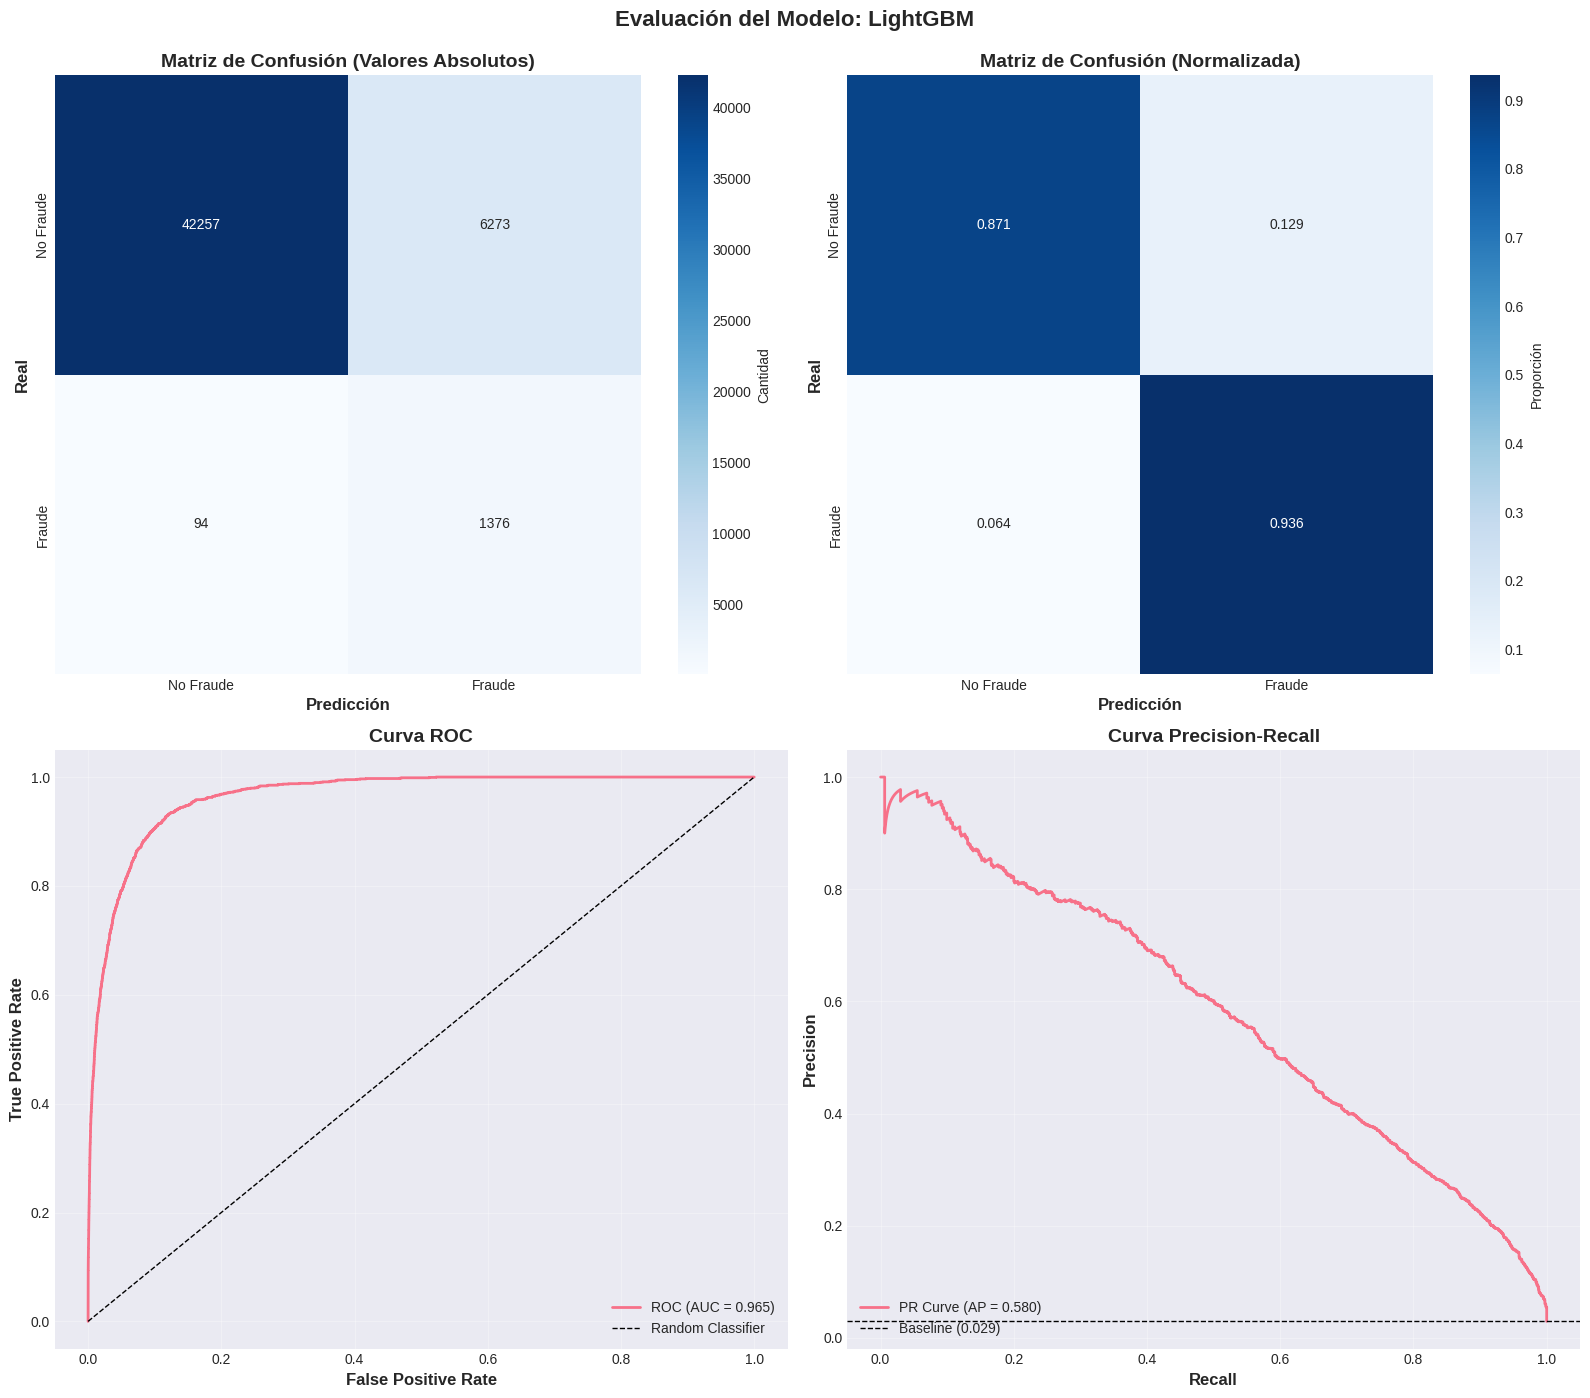

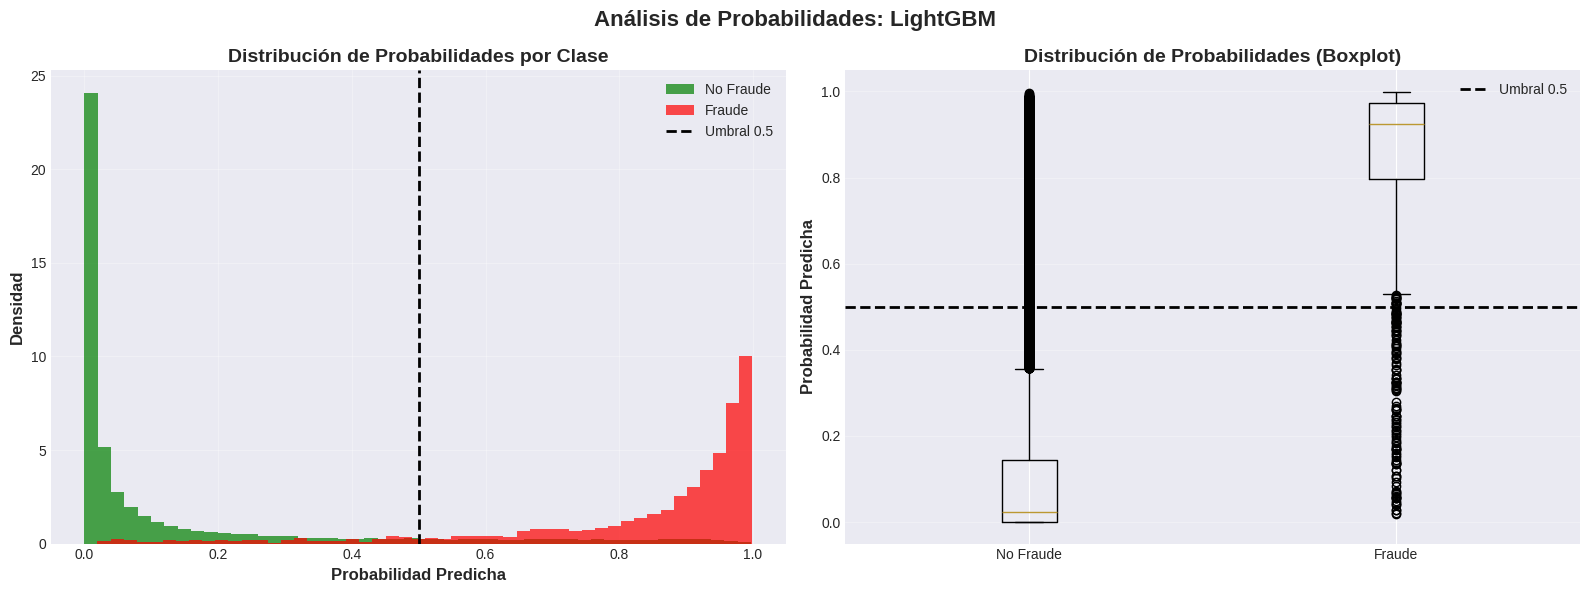

EVALUACIÓN DEL MODELO: XGBoost

📌 Threshold usado: 0.3313

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,530 (97.06%)
   Clase 1 (Fraude):    1,470 (2.94%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.8555
   F1 Score:            0.2786 ⭐
   Precision:           0.1632
   Recall (Sensitivity): 0.9490
   Specificity:         0.8526
   ROC AUC:             0.9642
   Average Precision:   0.5780

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.2404
   Matthews Corr Coef:  0.3597
   NPV:                 0.9982
   False Positive Rate: 0.1474

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.1632
   Recall:             0.9490
   F1 Score:           0.2786
   Cohen's Kappa:      0.2404
   Matthews Corr Coef: 0.3597
   Tasa positivos:     0.1709

💰 COSTO:
   Costo por 1000 registros: 1015.10
   (Costo FP: 5.0, Costo FN: 200.0)

🔢 MATRIZ DE CONFUSIÓN:
                    Predicción
                  No Fraude  Fraude
   Real No Fraude     41379 

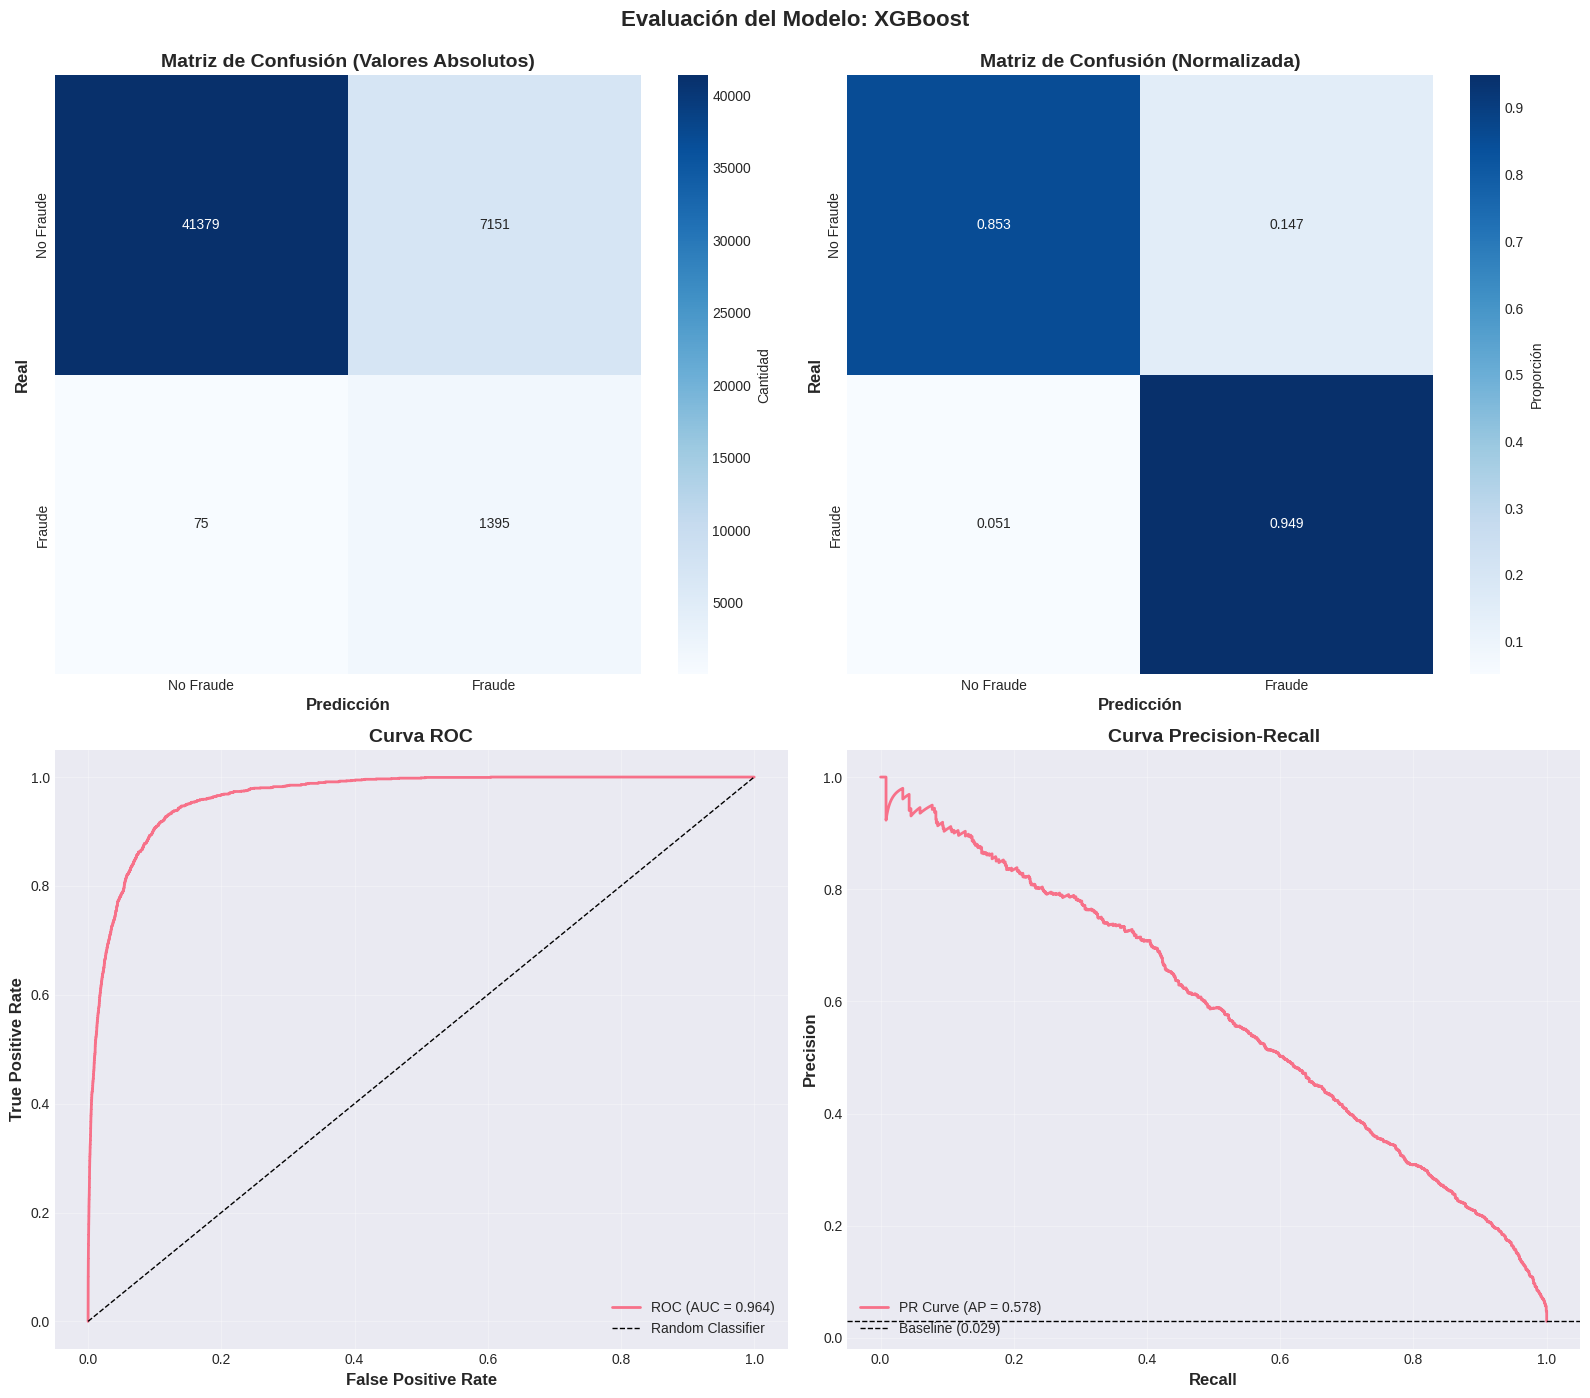

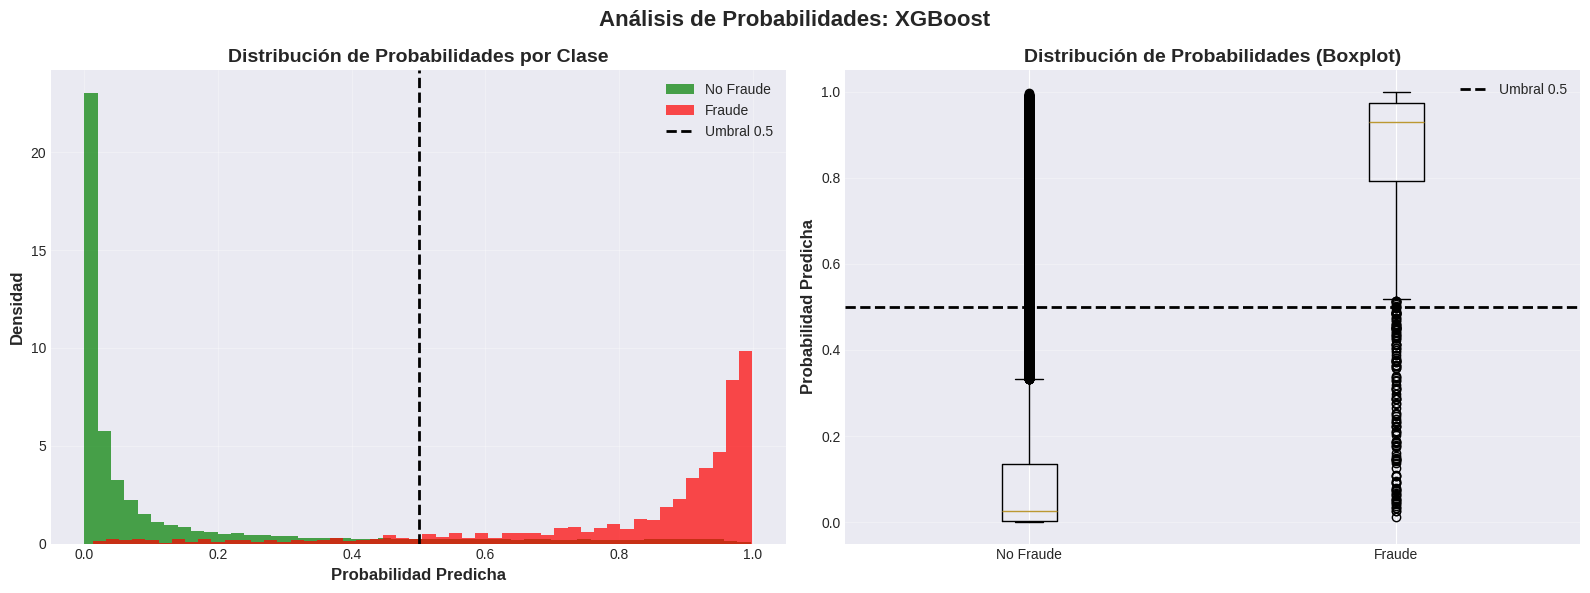

EVALUACIÓN DEL MODELO: CatBoost

📌 Threshold usado: 0.4317

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,530 (97.06%)
   Clase 1 (Fraude):    1,470 (2.94%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.8670
   F1 Score:            0.2937 ⭐
   Precision:           0.1740
   Recall (Sensitivity): 0.9401
   Specificity:         0.8648
   ROC AUC:             0.9635
   Average Precision:   0.5707

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.2568
   Matthews Corr Coef:  0.3720
   NPV:                 0.9979
   False Positive Rate: 0.1352

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.1740
   Recall:             0.9401
   F1 Score:           0.2937
   Cohen's Kappa:      0.2568
   Matthews Corr Coef: 0.3720
   Tasa positivos:     0.1588

💰 COSTO:
   Costo por 1000 registros: 1008.00
   (Costo FP: 5.0, Costo FN: 200.0)

🔢 MATRIZ DE CONFUSIÓN:
                    Predicción
                  No Fraude  Fraude
   Real No Fraude     41970

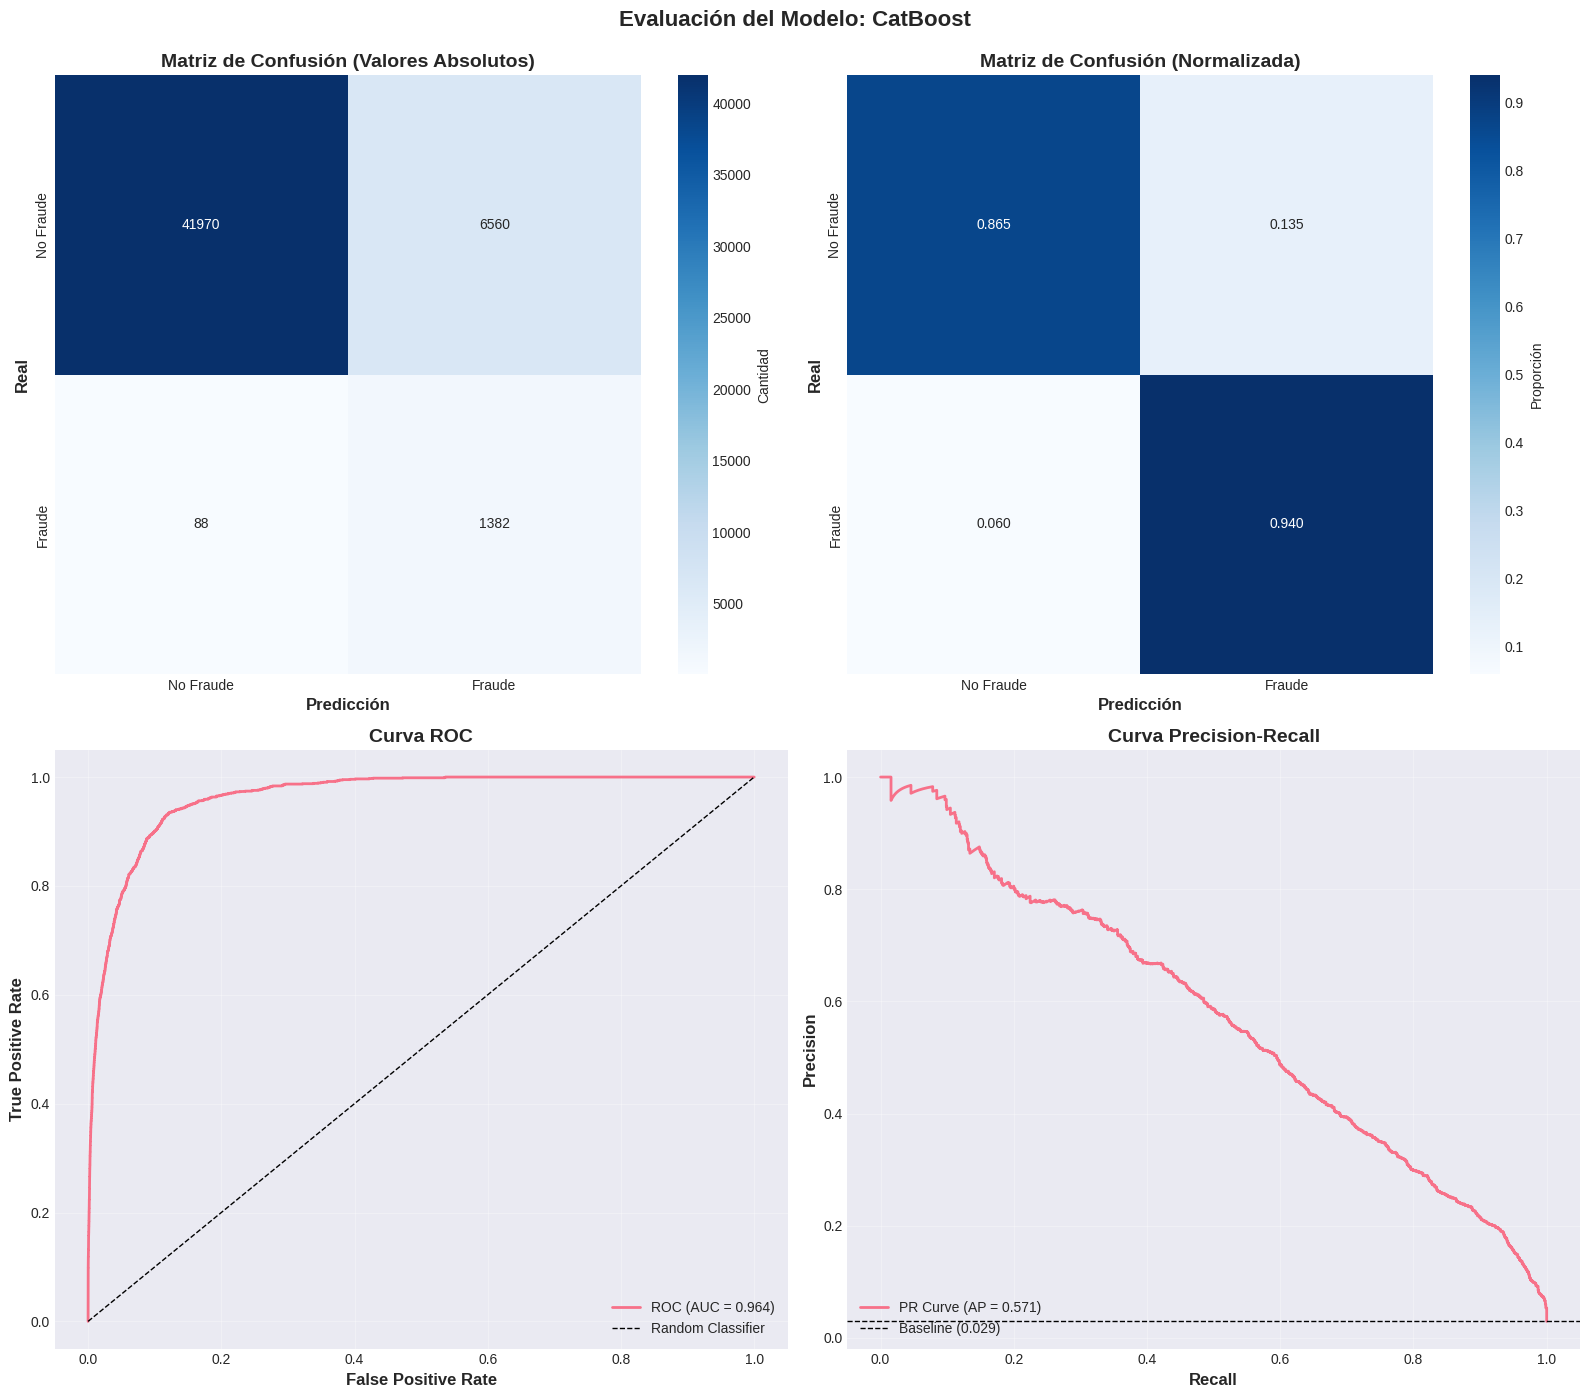

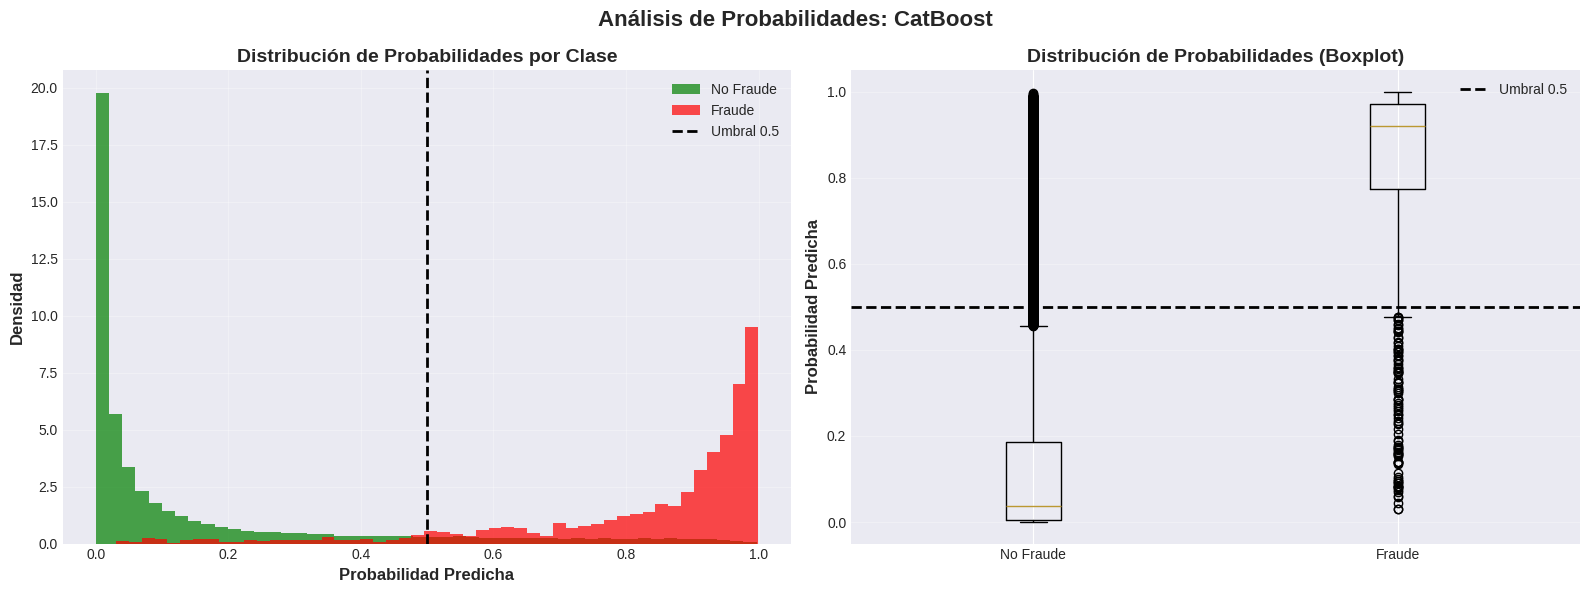

EVALUACIÓN DEL MODELO: Ensemble

📌 Threshold usado: 0.3463

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,530 (97.06%)
   Clase 1 (Fraude):    1,470 (2.94%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.8525
   F1 Score:            0.2747 ⭐
   Precision:           0.1606
   Recall (Sensitivity): 0.9503
   Specificity:         0.8495
   ROC AUC:             0.9648
   Average Precision:   0.5790

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.2363
   Matthews Corr Coef:  0.3564
   NPV:                 0.9982
   False Positive Rate: 0.1505

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.1606
   Recall:             0.9503
   F1 Score:           0.2747
   Cohen's Kappa:      0.2363
   Matthews Corr Coef: 0.3564
   Tasa positivos:     0.1740

💰 COSTO:
   Costo por 1000 registros: 1022.40
   (Costo FP: 5.0, Costo FN: 200.0)

🔢 MATRIZ DE CONFUSIÓN:
                    Predicción
                  No Fraude  Fraude
   Real No Fraude     41226

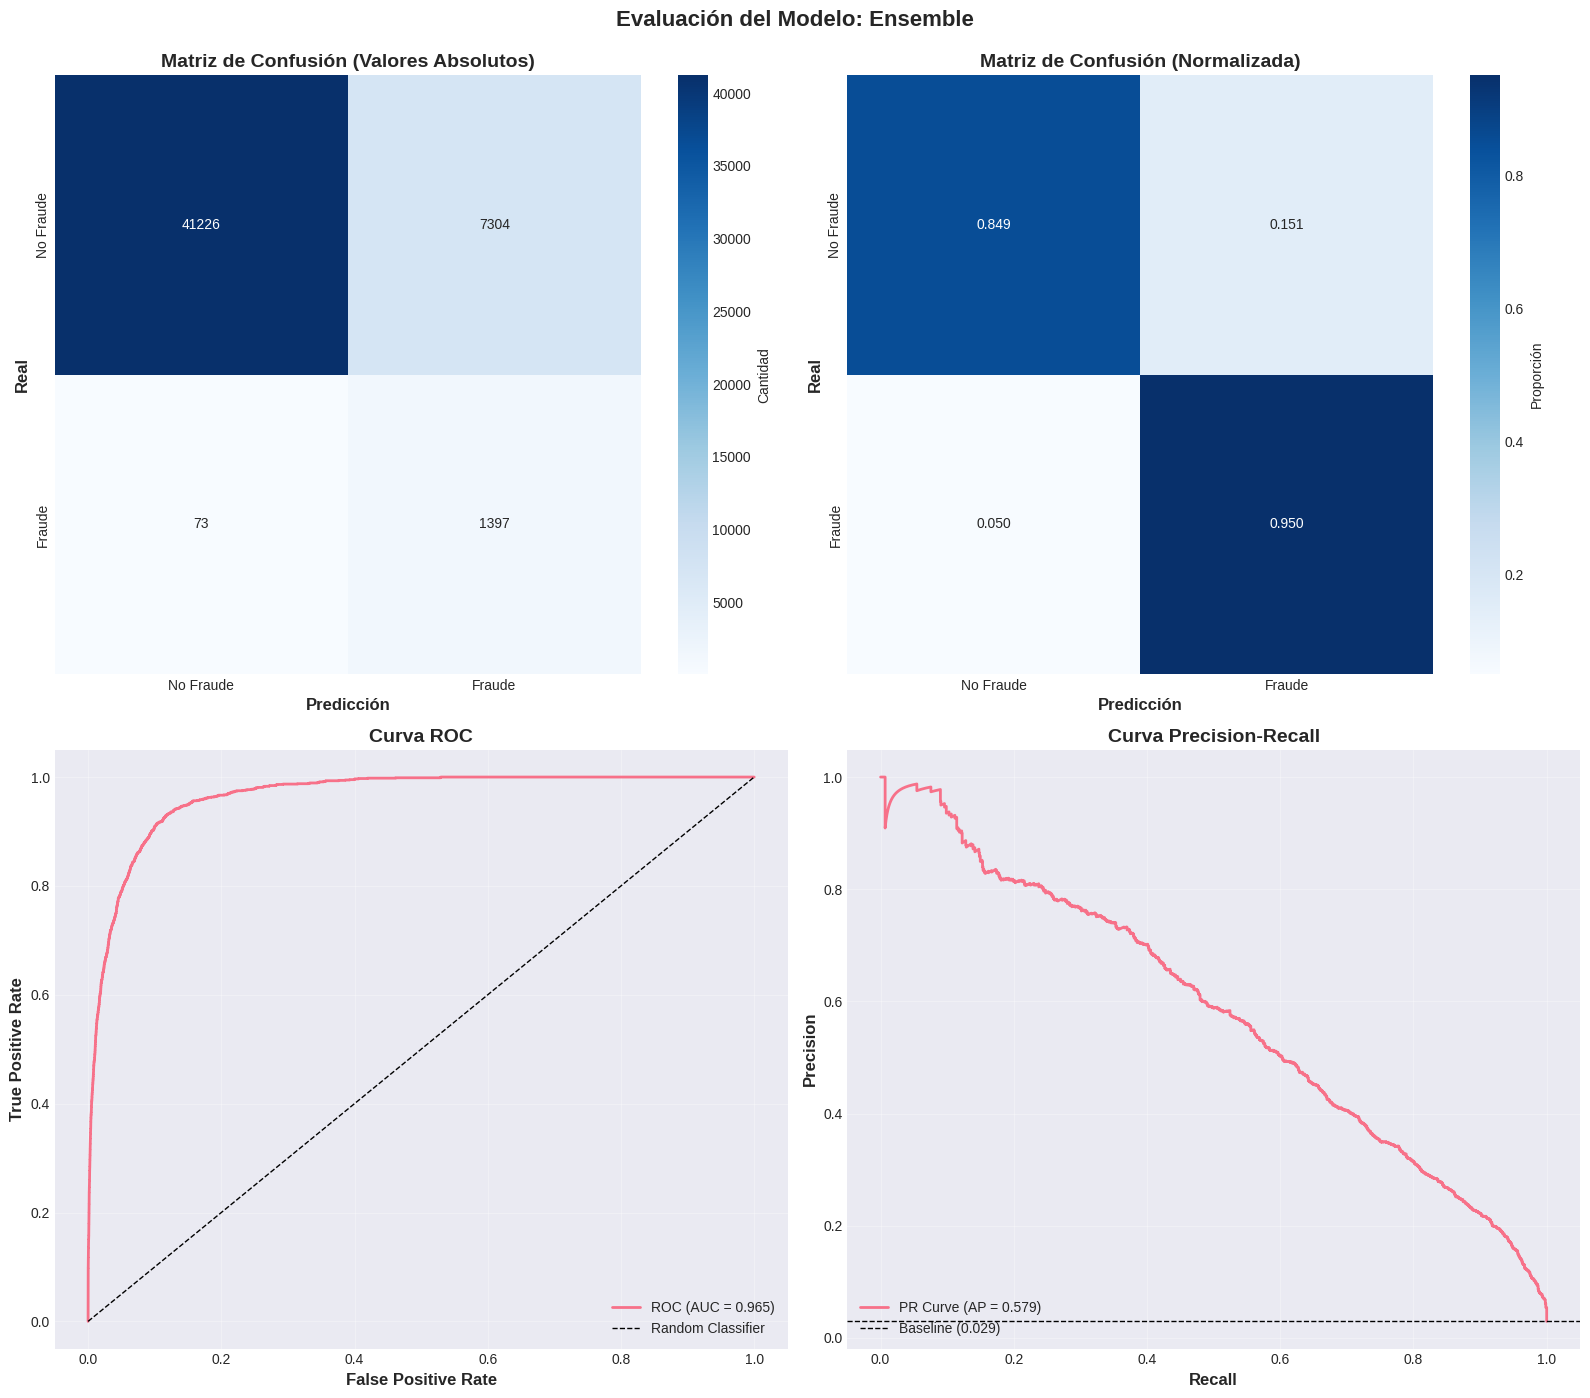

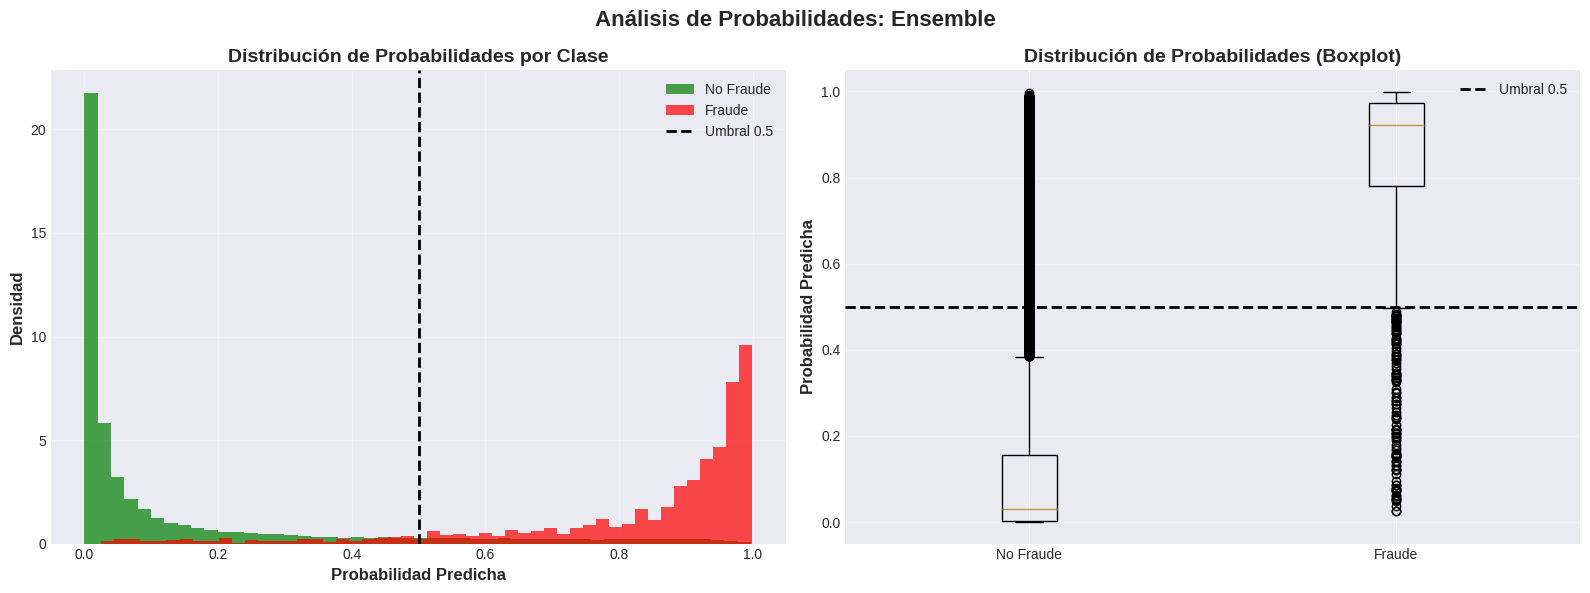


COMPARACIÓN DE COSTOS POR MODELO
Modelo               Costo/1000      Threshold    ROC AUC   
--------------------------------------------------------------------------------
LightGBM             $1003.30        0.4150       0.9651    
XGBoost              $1015.10        0.3313       0.9642    
CatBoost             $1008.00        0.4317       0.9635    
Ensemble             $1022.40        0.3463       0.9648    

🏆 MEJOR MODELO: LightGBM
Costo del mejor modelo: $1003.30 por 1000 registros
Costo de LightGBM solo: $1003.30 por 1000 registros
Mejora: $0.00 por 1000 registros
Reducción porcentual: 0.00%

💰 Ahorro anual estimado con LightGBM: $0.00


In [66]:
# Evaluar modelos individuales y ensemble en test set
print("=" * 80)
print("COMPARACIÓN DE MODELOS EN TEST SET")
print("=" * 80)

# Obtener probabilidades de cada modelo
y_proba_lightgbm = classifier_lightgbm.predict_proba(X_test)[:, 1]
y_proba_xgboost = classifier_xgboost.predict_proba(X_test)[:, 1]
y_proba_catboost = classifier_catboost.predict_proba(X_test)[:, 1]
y_proba_ensemble = ensemble.predict_proba(X_test)[:, 1]

# Evaluar cada modelo individual con su threshold óptimo
# Primero optimizamos threshold para XGBoost y CatBoost
print("\nOptimizando thresholds para XGBoost y CatBoost...")
resultados_xgboost = optimizar_threshold_costo_cv(
    model=classifier_xgboost,
    X=X_train,
    y=y_train,
    cv=cv,
    costo_fp=costo_fp,
    costo_fn=costo_fn,
    model_name="XGBoost"
)

resultados_catboost = optimizar_threshold_costo_cv(
    model=classifier_catboost,
    X=X_train,
    y=y_train,
    cv=cv,
    costo_fp=costo_fp,
    costo_fn=costo_fn,
    model_name="CatBoost"
)

threshold_xgboost = resultados_xgboost['threshold_optimo']
threshold_catboost = resultados_catboost['threshold_optimo']

# Evaluar en test
print("\n" + "=" * 80)
print("EVALUACIÓN EN TEST SET")
print("=" * 80)

# LightGBM
metrics_lightgbm = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_lightgbm,
    threshold=threshold_optimo,
    model_name="LightGBM",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)

# XGBoost
metrics_xgboost = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_xgboost,
    threshold=threshold_xgboost,
    model_name="XGBoost",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)

# CatBoost
metrics_catboost = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_catboost,
    threshold=threshold_catboost,
    model_name="CatBoost",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)

# Ensemble
metrics_ensemble = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_ensemble,
    threshold=threshold_ensemble,
    model_name="Ensemble",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)

# Comparar costos
print("\n" + "=" * 80)
print("COMPARACIÓN DE COSTOS POR MODELO")
print("=" * 80)
print(f"{'Modelo':<20} {'Costo/1000':<15} {'Threshold':<12} {'ROC AUC':<10}")
print("-" * 80)
print(f"{'LightGBM':<20} ${metrics_lightgbm['costo_por_1000']:<14.2f} {threshold_optimo:<12.4f} {metrics_lightgbm['roc_auc']:<10.4f}")
print(f"{'XGBoost':<20} ${metrics_xgboost['costo_por_1000']:<14.2f} {threshold_xgboost:<12.4f} {metrics_xgboost['roc_auc']:<10.4f}")
print(f"{'CatBoost':<20} ${metrics_catboost['costo_por_1000']:<14.2f} {threshold_catboost:<12.4f} {metrics_catboost['roc_auc']:<10.4f}")
print(f"{'Ensemble':<20} ${metrics_ensemble['costo_por_1000']:<14.2f} {threshold_ensemble:<12.4f} {metrics_ensemble['roc_auc']:<10.4f}")

# Encontrar mejor modelo
costos = {
    'LightGBM': metrics_lightgbm['costo_por_1000'],
    'XGBoost': metrics_xgboost['costo_por_1000'],
    'CatBoost': metrics_catboost['costo_por_1000'],
    'Ensemble': metrics_ensemble['costo_por_1000']
}

mejor_modelo = min(costos.items(), key=lambda x: x[1])
mejor_costo = mejor_modelo[1]
costo_lightgbm = costos['LightGBM']

print(f"\n{'='*80}")
print(f"🏆 MEJOR MODELO: {mejor_modelo[0]}")
print(f"{'='*80}")
print(f"Costo del mejor modelo: ${mejor_costo:.2f} por 1000 registros")
print(f"Costo de LightGBM solo: ${costo_lightgbm:.2f} por 1000 registros")
print(f"Mejora: ${costo_lightgbm - mejor_costo:.2f} por 1000 registros")
print(f"Reducción porcentual: {((costo_lightgbm - mejor_costo) / costo_lightgbm * 100):.2f}%")

# Calcular ahorro anual con el mejor modelo
ahorro_anual_mejor = (costo_lightgbm - mejor_costo) * 250 * 12  # 250k registros/mes * 12 meses
print(f"\n💰 Ahorro anual estimado con {mejor_modelo[0]}: ${ahorro_anual_mejor:,.2f}")

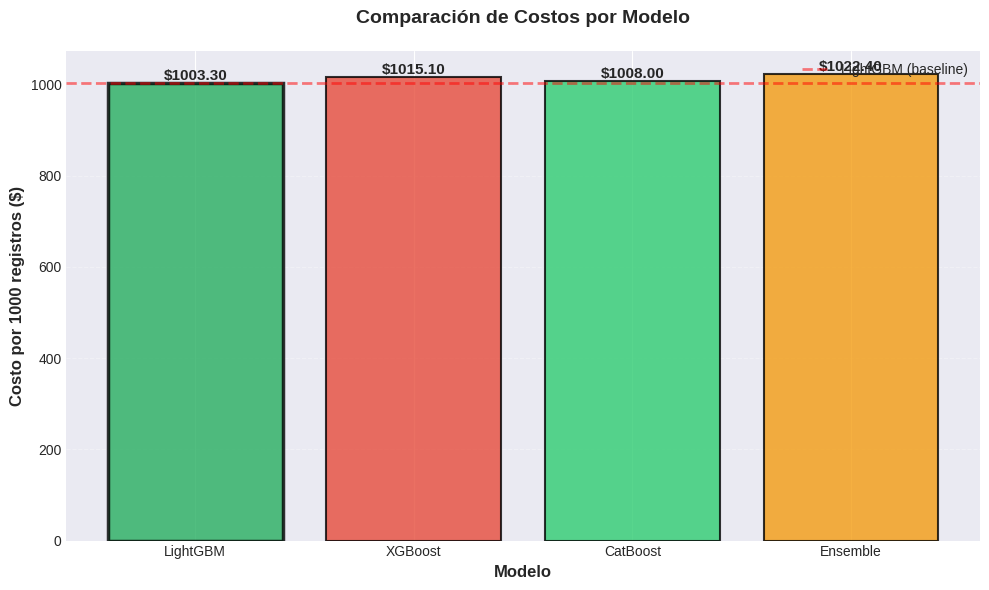


✅ Visualización generada


In [67]:
# Visualización comparativa de costos
fig, ax = plt.subplots(figsize=(10, 6))

modelos = list(costos.keys())
costos_valores = list(costos.values())
colores = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

bars = ax.bar(modelos, costos_valores, color=colores, alpha=0.8, edgecolor='black', linewidth=1.5)

# Agregar valores en las barras
for i, (bar, costo) in enumerate(zip(bars, costos_valores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${costo:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Resaltar el mejor modelo
mejor_idx = modelos.index(mejor_modelo[0])
bars[mejor_idx].set_color('#27ae60')
bars[mejor_idx].set_edgecolor('black')
bars[mejor_idx].set_linewidth(2.5)

ax.set_ylabel('Costo por 1000 registros ($)', fontsize=12, fontweight='bold')
ax.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Costos por Modelo', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Agregar línea de referencia (LightGBM)
ax.axhline(y=costo_lightgbm, color='red', linestyle='--', linewidth=2, alpha=0.5, label='LightGBM (baseline)')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("\n✅ Visualización generada")

Comparación del Costo Total de Fraude por Modelo


In [69]:
# Comparación completa del costo total de fraude para cada modelo
# Proyecciones mensuales y anuales

print("=" * 80)
print("COMPARACIÓN DEL COSTO TOTAL DE FRAUDE POR MODELO")
print("=" * 80)

# Obtener métricas de cada modelo
tn_lightgbm = metrics_lightgbm['true_negatives']
fp_lightgbm = metrics_lightgbm['false_positives']
fn_lightgbm = metrics_lightgbm['false_negatives']
tp_lightgbm = metrics_lightgbm['true_positives']

tn_xgboost = metrics_xgboost['true_negatives']
fp_xgboost = metrics_xgboost['false_positives']
fn_xgboost = metrics_xgboost['false_negatives']
tp_xgboost = metrics_xgboost['true_positives']

tn_catboost = metrics_catboost['true_negatives']
fp_catboost = metrics_catboost['false_positives']
fn_catboost = metrics_catboost['false_negatives']
tp_catboost = metrics_catboost['true_positives']

tn_ensemble = metrics_ensemble['true_negatives']
fp_ensemble = metrics_ensemble['false_positives']
fn_ensemble = metrics_ensemble['false_negatives']
tp_ensemble = metrics_ensemble['true_positives']

# Calcular costos totales en test set
costo_total_lightgbm = fp_lightgbm * costo_fp + fn_lightgbm * costo_fn
costo_total_xgboost = fp_xgboost * costo_fp + fn_xgboost * costo_fn
costo_total_catboost = fp_catboost * costo_fp + fn_catboost * costo_fn
costo_total_ensemble = fp_ensemble * costo_fp + fn_ensemble * costo_fn

# Calcular costo por registro
costo_por_registro_lightgbm = costo_total_lightgbm / len(y_test)
costo_por_registro_xgboost = costo_total_xgboost / len(y_test)
costo_por_registro_catboost = costo_total_catboost / len(y_test)
costo_por_registro_ensemble = costo_total_ensemble / len(y_test)

# Proyecciones
transacciones_mensuales = 250000
transacciones_anuales = transacciones_mensuales * 12

# Costos mensuales
costo_mensual_lightgbm = costo_por_registro_lightgbm * transacciones_mensuales
costo_mensual_xgboost = costo_por_registro_xgboost * transacciones_mensuales
costo_mensual_catboost = costo_por_registro_catboost * transacciones_mensuales
costo_mensual_ensemble = costo_por_registro_ensemble * transacciones_mensuales

# Costos anuales
costo_anual_lightgbm = costo_mensual_lightgbm * 12
costo_anual_xgboost = costo_mensual_xgboost * 12
costo_anual_catboost = costo_mensual_catboost * 12
costo_anual_ensemble = costo_mensual_ensemble * 12

# Costo sin modelo (todos los fraudes pasarían)
total_fraudes_test = tp_lightgbm + fn_lightgbm  # Usar cualquier modelo, todos tienen el mismo total
costo_sin_modelo_mensual = (total_fraudes_test / len(y_test)) * transacciones_mensuales * costo_fn
costo_sin_modelo_anual = costo_sin_modelo_mensual * 12

print(f"\n📊 DESGLOSE EN TEST SET ({len(y_test):,} registros):")
print(f"{'='*80}")
print(f"{'Modelo':<15} {'FP':<8} {'FN':<8} {'Costo Total':<15} {'Costo/1000':<12}")
print("-" * 80)
print(f"{'LightGBM':<15} {fp_lightgbm:<8,} {fn_lightgbm:<8,} ${costo_total_lightgbm:<14,.2f} ${metrics_lightgbm['costo_por_1000']:<11.2f}")
print(f"{'XGBoost':<15} {fp_xgboost:<8,} {fn_xgboost:<8,} ${costo_total_xgboost:<14,.2f} ${metrics_xgboost['costo_por_1000']:<11.2f}")
print(f"{'CatBoost':<15} {fp_catboost:<8,} {fn_catboost:<8,} ${costo_total_catboost:<14,.2f} ${metrics_catboost['costo_por_1000']:<11.2f}")
print(f"{'Ensemble':<15} {fp_ensemble:<8,} {fn_ensemble:<8,} ${costo_total_ensemble:<14,.2f} ${metrics_ensemble['costo_por_1000']:<11.2f}")

print(f"\n📊 PROYECCIÓN MENSUAL ({transacciones_mensuales:,} transacciones/mes):")
print(f"{'='*80}")
print(f"{'Modelo':<15} {'Costo Mensual':<20} {'Costo Anual':<20}")
print("-" * 80)
print(f"{'LightGBM':<15} ${costo_mensual_lightgbm:<19,.2f} ${costo_anual_lightgbm:<19,.2f}")
print(f"{'XGBoost':<15} ${costo_mensual_xgboost:<19,.2f} ${costo_anual_xgboost:<19,.2f}")
print(f"{'CatBoost':<15} ${costo_mensual_catboost:<19,.2f} ${costo_anual_catboost:<19,.2f}")
print(f"{'Ensemble':<15} ${costo_mensual_ensemble:<19,.2f} ${costo_anual_ensemble:<19,.2f}")
print(f"{'Sin Modelo':<15} ${costo_sin_modelo_mensual:<19,.2f} ${costo_sin_modelo_anual:<19,.2f}")

# Calcular ahorros
print(f"\n💰 AHORRO MENSUAL Y ANUAL vs Sin Modelo:")
print(f"{'='*80}")
print(f"{'Modelo':<15} {'Ahorro Mensual':<20} {'Ahorro Anual':<20} {'% Reducción':<15}")
print("-" * 80)

for nombre, costo_mensual, costo_anual in [
    ('LightGBM', costo_mensual_lightgbm, costo_anual_lightgbm),
    ('XGBoost', costo_mensual_xgboost, costo_anual_xgboost),
    ('CatBoost', costo_mensual_catboost, costo_anual_catboost),
    ('Ensemble', costo_mensual_ensemble, costo_anual_ensemble)
]:
    ahorro_mensual = costo_sin_modelo_mensual - costo_mensual
    ahorro_anual = costo_sin_modelo_anual - costo_anual
    reduccion_pct = (ahorro_mensual / costo_sin_modelo_mensual) * 100
    print(f"{nombre:<15} ${ahorro_mensual:<19,.2f} ${ahorro_anual:<19,.2f} {reduccion_pct:<14.2f}%")

# Comparar con el mejor modelo
print(f"\n🏆 COMPARACIÓN CON EL MEJOR MODELO ({mejor_modelo[0]}):")
print(f"{'='*80}")
print(f"{'Modelo':<15} {'Diferencia Mensual':<20} {'Diferencia Anual':<20}")
print("-" * 80)

# Obtener costos del mejor modelo
costos_mensuales = {
    'LightGBM': costo_mensual_lightgbm,
    'XGBoost': costo_mensual_xgboost,
    'CatBoost': costo_mensual_catboost,
    'Ensemble': costo_mensual_ensemble
}

costos_anuales = {
    'LightGBM': costo_anual_lightgbm,
    'XGBoost': costo_anual_xgboost,
    'CatBoost': costo_anual_catboost,
    'Ensemble': costo_anual_ensemble
}

mejor_costo_mensual = costos_mensuales[mejor_modelo[0]]
mejor_costo_anual = costos_anuales[mejor_modelo[0]]

for nombre in ['LightGBM', 'XGBoost', 'CatBoost', 'Ensemble']:
    if nombre != mejor_modelo[0]:
        diff_mensual = costos_mensuales[nombre] - mejor_costo_mensual
        diff_anual = costos_anuales[nombre] - mejor_costo_anual
        signo = "+" if diff_mensual > 0 else ""
        print(f"{nombre:<15} {signo}${diff_mensual:<18,.2f} {signo}${diff_anual:<18,.2f}")
    else:
        print(f"{nombre:<15} {'(MEJOR)':<20} {'(MEJOR)':<20}")

print(f"\n{'='*80}")
print(f"💡 RESUMEN:")
print(f"{'='*80}")
print(f"Mejor modelo: {mejor_modelo[0]}")
print(f"Costo mensual del mejor modelo: ${mejor_costo_mensual:,.2f}")
print(f"Costo anual del mejor modelo: ${mejor_costo_anual:,.2f}")
print(f"Ahorro anual vs sin modelo: ${costo_sin_modelo_anual - mejor_costo_anual:,.2f}")
print(f"Reducción de costo: {((costo_sin_modelo_anual - mejor_costo_anual) / costo_sin_modelo_anual * 100):.2f}%")


COMPARACIÓN DEL COSTO TOTAL DE FRAUDE POR MODELO

📊 DESGLOSE EN TEST SET (50,000 registros):
Modelo          FP       FN       Costo Total     Costo/1000  
--------------------------------------------------------------------------------
LightGBM        6,273    94       $50,165.00      $1003.30    
XGBoost         7,151    75       $50,755.00      $1015.10    
CatBoost        6,560    88       $50,400.00      $1008.00    
Ensemble        7,304    73       $51,120.00      $1022.40    

📊 PROYECCIÓN MENSUAL (250,000 transacciones/mes):
Modelo          Costo Mensual        Costo Anual         
--------------------------------------------------------------------------------
LightGBM        $250,825.00          $3,009,900.00       
XGBoost         $253,775.00          $3,045,300.00       
CatBoost        $252,000.00          $3,024,000.00       
Ensemble        $255,600.00          $3,067,200.00       
Sin Modelo      $1,470,000.00        $17,640,000.00      

💰 AHORRO MENSUAL Y ANUAL vs Si

In [ ]:
# Visualización comparativa del costo total anual
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Costo mensual
modelos = ['LightGBM', 'XGBoost', 'CatBoost', 'Ensemble', 'Sin Modelo']
costos_mensuales_plot = [
    costo_mensual_lightgbm,
    costo_mensual_xgboost,
    costo_mensual_catboost,
    costo_mensual_ensemble,
    costo_sin_modelo_mensual
]
colores = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#e74c3c']

bars1 = ax1.bar(modelos, costos_mensuales_plot, color=colores, alpha=0.8, edgecolor='black', linewidth=1.5)

# Resaltar el mejor modelo
mejor_idx = modelos.index(mejor_modelo[0])
bars1[mejor_idx].set_color('#27ae60')
bars1[mejor_idx].set_edgecolor('black')
bars1[mejor_idx].set_linewidth(2.5)

# Agregar valores en las barras
for bar, costo in zip(bars1, costos_mensuales_plot):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'${costo/1000:.1f}K',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_ylabel('Costo Mensual ($)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax1.set_title('Costo Total Mensual por Modelo', fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2: Costo anual
costos_anuales_plot = [
    costo_anual_lightgbm,
    costo_anual_xgboost,
    costo_anual_catboost,
    costo_anual_ensemble,
    costo_sin_modelo_anual
]

bars2 = ax2.bar(modelos, costos_anuales_plot, color=colores, alpha=0.8, edgecolor='black', linewidth=1.5)

# Resaltar el mejor modelo
bars2[mejor_idx].set_color('#27ae60')
bars2[mejor_idx].set_edgecolor('black')
bars2[mejor_idx].set_linewidth(2.5)

# Agregar valores en las barras
for bar, costo in zip(bars2, costos_anuales_plot):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${costo/1000000:.2f}M',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_ylabel('Costo Anual ($)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax2.set_title('Costo Total Anual por Modelo', fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✅ Visualización del costo total generada")


Costo Total de Fraude - Dataset Completo


In [70]:
# Calcular el costo total de fraude para TODO el dataset (250,000 registros) con cada modelo
print("=" * 80)
print("COSTO TOTAL DE FRAUDE - DATASET COMPLETO (250,000 registros)")
print("=" * 80)

# Obtener costos por 1000 registros de cada modelo
costo_por_1000_lightgbm = metrics_lightgbm['costo_por_1000']
costo_por_1000_xgboost = metrics_xgboost['costo_por_1000']
costo_por_1000_catboost = metrics_catboost['costo_por_1000']
costo_por_1000_ensemble = metrics_ensemble['costo_por_1000']

# Calcular costo total para el dataset completo
total_registros = len(y)  # 250,000 registros

costo_total_lightgbm = (costo_por_1000_lightgbm / 1000) * total_registros
costo_total_xgboost = (costo_por_1000_xgboost / 1000) * total_registros
costo_total_catboost = (costo_por_1000_catboost / 1000) * total_registros
costo_total_ensemble = (costo_por_1000_ensemble / 1000) * total_registros

# Calcular costo sin modelo (todos los fraudes pasarían)
total_fraudes_dataset = np.sum(y == 1)
costo_sin_modelo_dataset = total_fraudes_dataset * costo_fn

# Crear diccionario con todos los costos
costos_dataset = {
    'LightGBM': costo_total_lightgbm,
    'XGBoost': costo_total_xgboost,
    'CatBoost': costo_total_catboost,
    'Ensemble': costo_total_ensemble,
    'Sin Modelo': costo_sin_modelo_dataset
}

# Encontrar mejor modelo
mejor_modelo_dataset = min([k for k in costos_dataset.keys() if k != 'Sin Modelo'], 
                           key=lambda x: costos_dataset[x])
mejor_costo_dataset = costos_dataset[mejor_modelo_dataset]

print(f"\n📊 COSTO TOTAL PARA EL DATASET COMPLETO ({total_registros:,} registros):")
print("=" * 80)
print(f"{'Modelo':<15} {'Costo Total':<20} {'Costo/1000':<15} {'% del Total'}")
print("-" * 80)

for modelo, costo_total in costos_dataset.items():
    costo_por_1000 = (costo_total / total_registros) * 1000
    porcentaje = (costo_total / costo_sin_modelo_dataset) * 100 if costo_sin_modelo_dataset > 0 else 0
    
    # Marcar el mejor modelo
    marca = " 🏆" if modelo == mejor_modelo_dataset else ""
    print(f"{modelo:<15} ${costo_total:<19,.2f} ${costo_por_1000:<14.2f} {porcentaje:.2f}%{marca}")

print("\n" + "=" * 80)
print("💰 AHORRO CON CADA MODELO vs Sin Modelo:")
print("=" * 80)
print(f"{'Modelo':<15} {'Ahorro Total':<20} {'% Reducción':<15}")
print("-" * 80)

for modelo in ['LightGBM', 'XGBoost', 'CatBoost', 'Ensemble']:
    ahorro = costo_sin_modelo_dataset - costos_dataset[modelo]
    reduccion = (ahorro / costo_sin_modelo_dataset) * 100 if costo_sin_modelo_dataset > 0 else 0
    marca = " 🏆" if modelo == mejor_modelo_dataset else ""
    print(f"{modelo:<15} ${ahorro:<19,.2f} {reduccion:.2f}%{marca}")

print("\n" + "=" * 80)
print("📈 COMPARACIÓN RELATIVA AL MEJOR MODELO:")
print("=" * 80)
print(f"{'Modelo':<15} {'Diferencia vs Mejor':<20} {'% Más Costoso':<15}")
print("-" * 80)

for modelo in ['LightGBM', 'XGBoost', 'CatBoost', 'Ensemble']:
    if modelo == mejor_modelo_dataset:
        print(f"{modelo:<15} {'(MEJOR)':<20} {'0.00%':<15} 🏆")
    else:
        diferencia = costos_dataset[modelo] - mejor_costo_dataset
        porcentaje_extra = (diferencia / mejor_costo_dataset) * 100 if mejor_costo_dataset > 0 else 0
        print(f"{modelo:<15} +${diferencia:<18,.2f} +{porcentaje_extra:.2f}%")

print("\n" + "=" * 80)
print("💡 RESUMEN FINAL:")
print("=" * 80)
print(f"Mejor modelo: {mejor_modelo_dataset}")
print(f"Costo total del mejor modelo: ${mejor_costo_dataset:,.2f}")
print(f"Costo sin modelo: ${costo_sin_modelo_dataset:,.2f}")
print(f"Ahorro total con el mejor modelo: ${costo_sin_modelo_dataset - mejor_costo_dataset:,.2f}")
print(f"Reducción de costo: {((costo_sin_modelo_dataset - mejor_costo_dataset) / costo_sin_modelo_dataset * 100):.2f}%")
print(f"\nTotal de fraudes en el dataset: {total_fraudes_dataset:,}")
print(f"Fraudes detectados por el mejor modelo: ~{int(total_fraudes_dataset * (1 - (mejor_costo_dataset / costo_sin_modelo_dataset))):,}")
print("=" * 80)


COSTO TOTAL DE FRAUDE - DATASET COMPLETO (250,000 registros)

📊 COSTO TOTAL PARA EL DATASET COMPLETO (250,000 registros):
Modelo          Costo Total          Costo/1000      % del Total
--------------------------------------------------------------------------------
LightGBM        $250,825.00          $1003.30        16.72% 🏆
XGBoost         $253,775.00          $1015.10        16.91%
CatBoost        $252,000.00          $1008.00        16.80%
Ensemble        $255,600.00          $1022.40        17.04%
Sin Modelo      $1,500,400.00        $6001.60        100.00%

💰 AHORRO CON CADA MODELO vs Sin Modelo:
Modelo          Ahorro Total         % Reducción    
--------------------------------------------------------------------------------
LightGBM        $1,249,575.00        83.28% 🏆
XGBoost         $1,246,625.00        83.09%
CatBoost        $1,248,400.00        83.20%
Ensemble        $1,244,800.00        82.96%

📈 COMPARACIÓN RELATIVA AL MEJOR MODELO:
Modelo          Diferencia vs Mejor

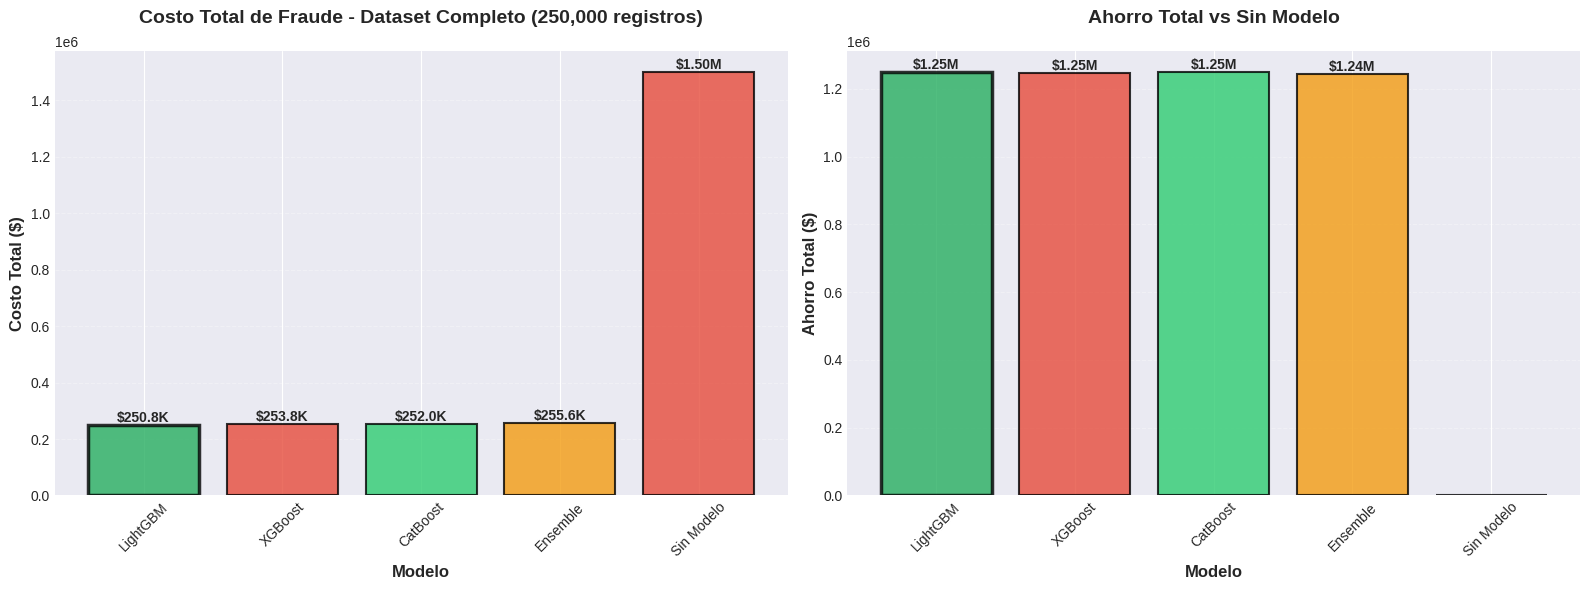


✅ Visualización del costo total del dataset completo generada


In [71]:
# Visualización comparativa del costo total del dataset completo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Costo total del dataset
modelos_plot = ['LightGBM', 'XGBoost', 'CatBoost', 'Ensemble', 'Sin Modelo']
costos_plot = [
    costo_total_lightgbm,
    costo_total_xgboost,
    costo_total_catboost,
    costo_total_ensemble,
    costo_sin_modelo_dataset
]
colores = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#e74c3c']

bars1 = ax1.bar(modelos_plot, costos_plot, color=colores, alpha=0.8, edgecolor='black', linewidth=1.5)

# Resaltar el mejor modelo
mejor_idx_plot = modelos_plot.index(mejor_modelo_dataset)
bars1[mejor_idx_plot].set_color('#27ae60')
bars1[mejor_idx_plot].set_edgecolor('black')
bars1[mejor_idx_plot].set_linewidth(2.5)

# Agregar valores en las barras
for bar, costo in zip(bars1, costos_plot):
    height = bar.get_height()
    if costo >= 1000000:
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${costo/1000000:.2f}M',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    else:
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${costo/1000:.1f}K',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_ylabel('Costo Total ($)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax1.set_title(f'Costo Total de Fraude - Dataset Completo ({total_registros:,} registros)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2: Ahorro vs Sin Modelo
ahorros_plot = [
    costo_sin_modelo_dataset - costo_total_lightgbm,
    costo_sin_modelo_dataset - costo_total_xgboost,
    costo_sin_modelo_dataset - costo_total_catboost,
    costo_sin_modelo_dataset - costo_total_ensemble,
    0  # Sin modelo no tiene ahorro
]

bars2 = ax2.bar(modelos_plot, ahorros_plot, color=colores, alpha=0.8, edgecolor='black', linewidth=1.5)

# Resaltar el mejor modelo
bars2[mejor_idx_plot].set_color('#27ae60')
bars2[mejor_idx_plot].set_edgecolor('black')
bars2[mejor_idx_plot].set_linewidth(2.5)

# Agregar valores en las barras
for bar, ahorro in zip(bars2, ahorros_plot):
    if ahorro > 0:
        height = bar.get_height()
        if ahorro >= 1000000:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'${ahorro/1000000:.2f}M',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
        else:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'${ahorro/1000:.1f}K',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_ylabel('Ahorro Total ($)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax2.set_title('Ahorro Total vs Sin Modelo', fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✅ Visualización del costo total del dataset completo generada")

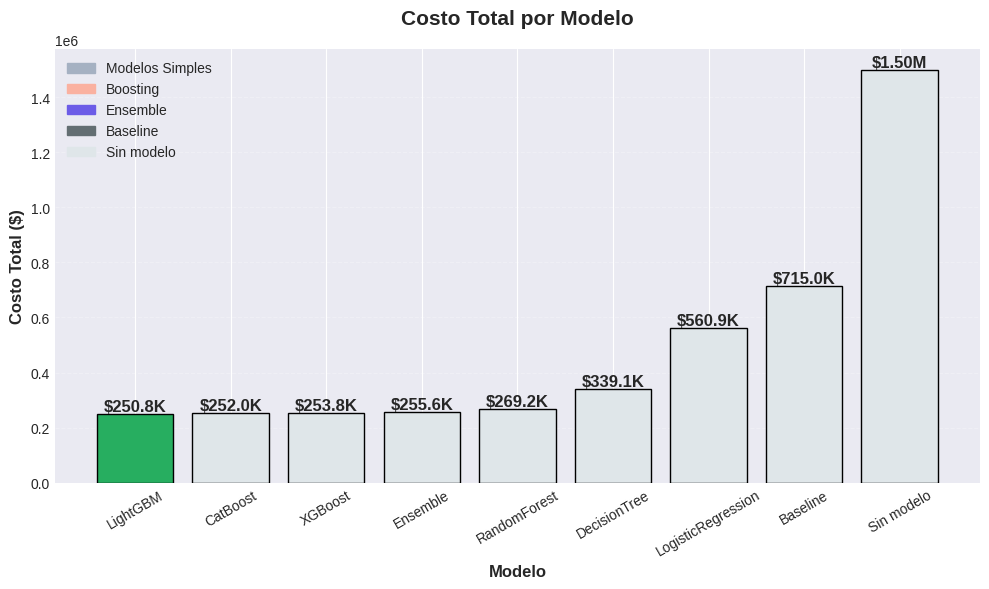

In [87]:
import matplotlib.pyplot as plt

# Definir colores por grupos de modelos
color_gris_claro = '#dfe6e9'     # Gris claro para todos menos LightGBM
color_lightgbm = '#27ae60'       # Verde para resaltar LightGBM (puedes cambiar el color si prefieres otro)

# Crear lista de tuplas (modelo, costo, color en grupos)
modelos_costos_colores = [
    ('Baseline',           715000,                  color_gris_claro),      # Baseline
    ('DecisionTree',       339075,                  color_gris_claro),      # Simples
    ('RandomForest',       269250,                  color_gris_claro),      # Simples
    ('LogisticRegression', 560875,                  color_gris_claro),      # Simples
    ('LightGBM',           costo_total_lightgbm,    color_lightgbm),        # LightGBM resaltado
    ('XGBoost',            costo_total_xgboost,     color_gris_claro),      # Boosting
    ('CatBoost',           costo_total_catboost,    color_gris_claro),      # Boosting
    ('Ensemble',           costo_total_ensemble,    color_gris_claro),      # Ensemble
    ('Sin modelo',         costo_sin_modelo_dataset,color_gris_claro)       # Sin modelo
]

# Ordenar por costo total de menor a mayor
modelos_costos_colores_ordenados = sorted(modelos_costos_colores, key=lambda x: x[1])

# Separar los valores ordenados
modelos_sorted = [x[0] for x in modelos_costos_colores_ordenados]
costos_sorted = [x[1] for x in modelos_costos_colores_ordenados]
colores_sorted = [x[2] for x in modelos_costos_colores_ordenados]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(modelos_sorted, costos_sorted, color=colores_sorted, edgecolor='black')

# Mostrar valores arriba de las barras
for bar, costo in zip(bars, costos_sorted):
    if costo >= 1_000_000:
        txt = f"${costo/1_000_000:.2f}M"
    else:
        txt = f"${costo/1000:.1f}K"
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), txt,
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Costo Total ($)', fontsize=12, fontweight='bold')
ax.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax.set_title('Costo Total por Modelo', fontsize=15, fontweight='bold', pad=18)
ax.grid(axis='y', alpha=0.25, linestyle='--')
ax.set_axisbelow(True)
ax.tick_params(axis='x', rotation=30)

# Agregar leyenda manual por grupos
import matplotlib.patches as mpatches
ax.legend(handles=legend_patches, loc='upper left', frameon=False)

plt.tight_layout()
plt.show()
